# Modelling demand response: comparison of modelling approaches

## Purpose and background

* This notebook is based on an implementation of Julian Endres created within the wind note project, see: https://github.com/windnode/SinkDSM_example/blob/master/DSM-Modelling.ipynb
* It's main purpose is to compare different implementations for demand response modelling.
* The modelling approaches considered are the following ones:
    * Zerrahn & Schill (2015)
    * Steurer (2017)
    * Gils (2015)
    * Ladwig (2018)

## Method

To compare the modelling approaches, the following methodology is applied:
* A toy model is set up
* Different situations are depicted using the toy model:
    * Constant demand & generation throughout
    * Constant demand & varying generation
    * Varying demand & constant generation
    * Both varying demand & varying generation
* In addition to that, a more realistic example model is considered as well.
* For all approaches, a separate model instance is created containing the respective demand response component. Hereby the same parametrization is used - as far as possible
* A benchmark is carried out, whereby the following elements are evaluated:
    * (Overall) amount of DSM activations
        * Capacity shifted
        * Energy shifted
    * DSM patterns
    * Overall system costs
    * Runtime / solver time
* Some of the benchmarks are only evaluated for certain model configurations.

# Package Imports
* Standard imports
* Import the different implementations for demand response components
* Import module `plotting.py` for extracting results and visualization

In [1]:
import pandas as pd
import numpy as np
import os
import pprint

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

import oemof.solph as solph
from oemof.network.network import Node

# Import the different alternative implementations
import oemof_SinkDSM as DSM_DIW
import oemof_DR_component_DLR_naming_adjusted as DSM_DLR
import oemof_DR_component_DLR_naming_adjusted_shifting_classes as DSM_DLR_ShiftClass
import oemof_DR_component_DLR_naming_adjusted_no_shed as DSM_DLR_NoShed
import oemof_DR_component_IER_naming_adjusted as DSM_IER
import oemof_DR_component_TUD_naming_adjusted as DSM_TUD

# Import module for plotting (results handling)
import plotting as plt_dsm

In [2]:
register_matplotlib_converters()

In [3]:
## base dataset
plt_dsm.make_directory('graphics')

----------------------------------------------------------
Folder "graphics" already exists in current directory.
----------------------------------------------------------


# Parameter settings
* General parameter settings for controlling the notebooks workflow
* Special parameter settings for DSM parameterization

## General parameter settings
Control **workflow** of notebook:
* *version*: One of 'simple' or 'advanced' &rarr; Determines the structure and duration of demand and generation peaks / drops
* *save_figs*: If True, all figures will be saved in the graphics folder.
* *save_results*: If True, overall amounts of demand response activations will be saved to .csv files

In [4]:
# Parameters to control overall workflow
version = 'simple'
#version = 'advanced'
save_figs = True
save_results = True

## DSM parameter settings
Define major **parameters concerning demand response modelling**
* *aproaches*: List of the approaches used for demand response modelling
* *addition*: Boolean parameter indicating, whether or not to include an additional "logic" constraint into the other DSM modelling approaches that is similar to equation 10 of Zerrahn & Schill (2015)
* *efficiency*: Consider a pontential efficiency loss for those modelling approaches which depict DSM efficiency (all except for Ladwig 2018).
* *recovery_time*: Consider a pontential recovery time for those modelling approaches which depict it (only Zerrahn & Schill 2015).
* *ActivateYearLimit*: Boolean variable indicating whether or not to use a limit for DSM activations per year (only applicable for Gils 2015).
* *ActivateDayLimit*: Boolean variable indicating whether or not to use a limit for DSM activations per day resp. per rolling window (only applicable for Gils 2015).

Determine **costs for demand response**:
* *include_costs*: If True, (small) variable costs will be included.
* *cost_dsm*: Overall variable costs for demand response which have to be splitted up to up and downwards shifts
* *cost_dsm_up*: Costs for upwards shifts (_defaults to have of the overall costs_)
* *cost_dsm_down*: Costs for downwards shifts (_defaults to have of the overall costs_)

Introduce special control variables for controlling the **workflow**, especially for approach from DLR (Gils 2015):
* *introduce_second_dsm_unit*: If True, a second demand response unit with the same parameterization will be introduced.
* *few_timesteps*: If True, for the simple example the timeset will be limited to 9 timesteps in order to increase readability of the .lp-files
* *use_shifting_classes*: If True, shifting classes will be applied in the approach from DLR (Gils 2015)
* *use_no_shed*: If True, the approach from DLR (Gils 2015) withouth a load shedding implementation will be utilized. 

In [5]:
# Parameters focussing on demand response modelling
approaches = ["DIW", "DLR", "IER", "TUD"]
addition = False
efficiency = 1
recovery_time = None
ActivateYearLimit = False
ActivateDayLimit = False

# Determine cost consideration
include_costs = True

if include_costs:
    cost_dsm = 0.1

else:
    cost_dsm = 0

# Cost is split half on upwards and downwards shift; shedding gets high costs
cost_dsm_up = cost_dsm/2
cost_dsm_down_shift = cost_dsm/2
cost_dsm_down_shed = 1000 * cost_dsm

In [6]:
# Control variables for demand response modelling
introduce_second_dsm_unit = False
few_timesteps = True

# Define whether or not to use the shifting classes approach for DLR (Gils 2015) -> not working yet!
use_no_shed = True
use_shifting_classes = False

# Tools for setting up a toy energy system model
For the testing, a **toy energy system** is set up including:
- Coal PP
- Wind PP
- PV PP
- DSM Sink
- shortage
- excess

**Rules for DSM parametrization**:

The following rules apply for parameters which are not part of every modelling approach:<br>
__*NOTE: These rules may / should be altered later to see the effect of the individual parameter!*__
* shift (resp. interference) times: These will be defined half of the delay time and symmetrical in the first place.
* optional parameters & constraints: These will be ignored in the first place.
* additional constraints: These will also be ignored in the first place.

## Create and solve the model
A function is defined here for setting up and solving the toy model.

In [7]:
def create_model(data, datetimeindex, directory, project, approach,
                 delay_time, shed_time, cost_dsm_up, cost_dsm_down_shift, 
                 cost_dsm_down_shed, efficiency,
                 shed_eligibility, shift_eligibility, introduce_second_dsm_unit,
                 **kwargs):
    """ Function to create and solve the model. """
    
    # Special kwargs (one approach only)
    method = kwargs.get('method', 'delay')
    shift_interval = kwargs.get('shift_interval', 24)
    recovery_time_shift = kwargs.get('recovery_time_shift', None)
    recovery_time_shed = kwargs.get('recovery_time_shed', 24)
    use_no_shed = kwargs.get('use_no_shed', False)
    use_shiting_classes = kwargs.get('use_shifting_classes', False)
    
    addition = kwargs.get('addition', 24)
    
    ActivateYearLimit = kwargs.get('ActivateYearLimit', False)
    ActivateDayLimit = kwargs.get('ActivateDayLimit', False)
    n_yearLimit_shift = kwargs.get('n_yearLimit_shift', 0)
    n_yearLimit_shed = kwargs.get('n_yearLimit_shed', 0)
    t_dayLimit = kwargs.get('t_dayLimit', 0)
    

    # ----------------- Energy System ----------------------------
    
    # Create Energy System
    es = solph.EnergySystem(timeindex=datetimeindex)
                           #groupings=[type])
    Node.registry = es

    # Create Busses
    b_coal_1 = solph.Bus(label='bus_coal_1')
    b_elec = solph.Bus(label='bus_elec')

    # Create Sources
    s_coal_p1 = solph.Source(label='source_coal_p1',
                             outputs={
                                b_coal_1: solph.Flow(
                                    nominal_value=10000,
                                    variable_costs=13)}
                             )

    s_wind = solph.Source(label='wind',
                          outputs={
                              b_elec: solph.Flow(
                                  fix=data['wind'][datetimeindex],
                                  nominal_value=1)}
                          )

    s_pv = solph.Source(label='pv',
                        outputs={
                            b_elec: solph.Flow(
                                fix=data['pv'][datetimeindex],
                                nominal_value=1)}
                        )

    # Create Transformer
    cfp_1 = solph.Transformer(label='pp_coal_1',
                              inputs={b_coal_1: solph.Flow()},
                              outputs={
                                  b_elec: solph.Flow(
                                      variable_costs=0)},
                              conversion_factors={b_elec: 0.4}
                              )
    
    # Create DSM units

    # Define kwargs that are identical for all DSM units
    kwargs_all = {'label': 'demand_dsm',
                  'inputs': {b_elec: solph.Flow(variable_costs=0)},
                  'demand': data['demand_el'][datetimeindex],
                  'capacity_up': data['Cap_up'][datetimeindex],
                  'capacity_down': data['Cap_do'][datetimeindex],
                  'delay_time': delay_time,
                  'shed_time': shed_time,
                  'cost_dsm_up': cost_dsm_up,
                  'cost_dsm_down_shift': cost_dsm_down_shift,
                  'cost_dsm_down_shed': cost_dsm_down_shed,
                  'efficiency': efficiency,
                  'shed_eligibility': shed_eligibility,
                  'shift_eligibility': shift_eligibility}
    
    # Define kwargs that differ dependent on approach chosen
    kwargs_dict = {
        'DIW': {'method': 'delay',
                'shift_interval': shift_interval,
                'recovery_time_shift': recovery_time_shift,
                'recovery_time_shed': recovery_time_shed},
                   
        'IER': {'shift_time_up': delay_time/2,
                'shift_time_down': delay_time/2,
                'cumulative_shift_time': len(data.loc[datetimeindex,:]),
                'cumulative_shed_time': len(data.loc[datetimeindex,:]),
                'addition': addition},
        
        'DLR': {'shift_time': delay_time/2,
                'ActivateYearLimit': ActivateYearLimit,
                'ActivateDayLimit': ActivateDayLimit,
                'n_yearLimit_shift': n_yearLimit_shift,
                'n_yearLimit_shed': n_yearLimit_shed,
                't_dayLimit': t_dayLimit,
                'addition': addition},
        
        'TUD': {'shift_time_down': delay_time/2,
                'postpone_time': delay_time/2,
                'annual_frequency_shift': len(data.loc[datetimeindex,:])/delay_time,
                'annual_frequency_shed': len(data.loc[datetimeindex,:])/shed_time,
                'daily_frequency_shift': 24/delay_time,
                'addition': addition}
                  }    
    
    # Create a second (identical) dsm unit for testing purposes
    # TODO: Fix this -> does not work (yet)!
    # Throws a key error
    # There seems to be a problem with the grouping not working properly!
    # But oddly it works for oemof.solph.custom.Link which has a pretty similar implementation ...
    
    # Optionally attribute half of the potential to a second identical dsm unit with a new label
    if introduce_second_dsm_unit:
        kwargs_all['demand'] = kwargs_all['demand']/2
        kwargs_all['capacity_up'] = kwargs_all['capacity_up']/2
        kwargs_all['capacity_down'] = kwargs_all['capacity_down']/2
        
        kwargs_all_manipulated = kwargs_all.copy()
        kwargs_all_manipulated['label'] = 'demand_dsm2'
    
    # Actually build the units
    if approach == "DIW":
            
        demand_dsm = DSM_DIW.SinkDSM(**kwargs_all,
                                     **kwargs_dict[approach])
        
        if introduce_second_dsm_unit:
            demand_dsm2 = DSM_DIW.SinkDSM(**kwargs_all_manipulated,
                                          **kwargs_dict[approach])

    elif approach == "IER":
        demand_dsm = DSM_IER.SinkDSI(**kwargs_all,
                                     **kwargs_dict[approach])
        
        if introduce_second_dsm_unit:
            demand_dsm2 = DSM_IER.SinkDSI(**kwargs_all_manipulated,
                                          **kwargs_dict[approach])
    
    elif approach == "DLR":
        
        # Use approach without shifing classes but with shedding
        if not (use_no_shed or use_shifting_classes):
            demand_dsm = DSM_DLR.SinkDR(**kwargs_all,
                                        **kwargs_dict[approach])
        
        # Use approach without shedding (and without shifting classes)
        elif use_no_shed:
            demand_dsm = DSM_DLR_NoShed.SinkDR(**kwargs_all,
                                               **kwargs_dict[approach])
            

            if introduce_second_dsm_unit:
                demand_dsm2 = DSM_DLR_NoShed.SinkkDR(**kwargs_all_manipulated,
                                                     **kwargs_dict[approach])
        
        # Use approach with shifing classes
        else:
            demand_dsm = DSM_DLR_ShiftClass.SinkDSM(**kwargs_all,
                                                    **kwargs_dict[approach])

    elif approach == "TUD":
        demand_dsm = DSM_TUD.SinkDSM(**kwargs_all,
                                     **kwargs_dict[approach])

        if introduce_second_dsm_unit:
            demand_dsm2 = DSM_TUD.SinkDSM(**kwargs_all_manipulated,
                                          **kwargs_dict[approach])
    
    else:
        raise ValueError("No valid value for approach. Must be one of ['DIW', 'IER', 'DLR', 'TUD']")

    # Backup excess / shortage
    excess = solph.Sink(label='excess_el',
                        inputs={b_elec: solph.Flow(variable_costs=1)}
                        )

    s_shortage_el = solph.Source(label='shortage_el',
                                 outputs={
                                     b_elec: solph.Flow(
                                         variable_costs=200)}
                                 )

    # -------------------------- Create Model ----------------------
       
    # Create Model
    model = solph.Model(es)

    # Solve Model
    model.solve(solver='gurobi', solve_kwargs={'tee': False})

    # Write LP File
    filename = os.path.join(os.path.dirname('__file__'), directory, project +'.lp')
    model.write(filename, io_options={'symbolic_solver_labels': True})

    # Save Results
    es.results['main'] = solph.processing.results(model)
    es.results['meta'] = solph.processing.meta_results(model)
    es.dump(dpath=None, filename=None)

    return model

## Extract model results and plot the model
A function is defined here to extract results from the model and plot the model results.

In [8]:
def start_model(df_data, timesteps, **kwargs):
    """ Function to extract model results and plot the model. """
    
    approach = kwargs.get('approach', 'DIW')
    
    # Control plotting and processing
    case = kwargs.get('case', 'constant') 
    plot = kwargs.get('plot', False)
    figure_size = kwargs.get('figsize', (15,10))
    show = kwargs.get('show', False)
    save = kwargs.get('save', False)
    
    # ----------------- Input Data & Timesteps ----------------------------

    # Provide directory
    project = 'demand_shift_' + approach + '_' + case
    directory = './'

    # Data manipulation
    data = df_data

    # Timestamp
    datetimeindex = pd.date_range(start='1/1/2013',
                                  periods=timesteps,
                                  freq='H')
    
    # ----------------- DSM Parameterization ----------------------------
    
    introduce_second_dsm_unit = kwargs.get('introduce_second_dsm_unit', False)
    
    # kwargs for all approaches
    delay_time = kwargs.get('delay_time', 1)
    shed_time = kwargs.get('shed_time', 1)
    cost_dsm_up = kwargs.get('cost_dsm_up', 0)
    cost_dsm_down_shift = kwargs.get('cost_dsm_down_shift', 0)
    cost_dsm_down_shed = kwargs.get('cost_dsm_down_shed', 0)
    efficiency = kwargs.get('efficiency', 1)
    shed_eligibility = kwargs.get('shed_eligibility', False)
    shift_eligibility = kwargs.get('shift_eligibility', True)
    
    # kwargs that differ dependent on approach chosen
    kwargs_dict = {
        'DIW': {'method': kwargs.get('method', None),
                'shift_interval': kwargs.get('shift_interval', None),
                'recovery_time_shift': kwargs.get('recovery_time_shift', None),
                'recovery_time_shed': kwargs.get('recovery_time_shed', 24)},
                   
        'IER': {'shift_time_up': delay_time/2,
                'shift_time_down': delay_time/2,
                'cumulative_shift_time': len(data.loc[datetimeindex,:]),
                'cumulative_shed_time': len(data.loc[datetimeindex,:]),
                'addition': kwargs.get('addition', False)},
        
        'DLR': {'shift_time': delay_time/2,
                'ActivateYearLimit': kwargs.get('ActivateYearLimit', False),
                'ActivateDayLimit': kwargs.get('ActivateDayLimit', False),
                'n_yearLimit_shift': kwargs.get('n_yearLimit_shift', 0),
                'n_yearLimit_shed': kwargs.get('n_yearLimit_shed', 0),
                't_dayLimit': kwargs.get('t_dayLimit', 0),
                'addition': kwargs.get('addition', False)},
        
        'TUD': {'shift_time_down': delay_time/2,
                'postpone_time': delay_time/2,
                'annual_frequency_shift': len(data.loc[datetimeindex,:])/delay_time,
                'annual_frequency_shed': len(data.loc[datetimeindex,:])/shed_time,
                'daily_frequency_shift': 24/delay_time,
                'addition': kwargs.get('addition', False)}              
                  }   

    # Introduce another dict for controlling the approaches workflows
    # So far, these only apply for DLR approach (might be removed later on)
    control_dict = {
        'DIW':{},
        'IER':{},
        'DLR':{'use_no_shed': kwargs.get('use_no_shed', True),
               'use_shifting_classes': kwargs.get('use_shifting_classes', False)},
        'TUD':{}      
    }
    
    # ----------------- Create & Solve Model ----------------------------

    # Create model   
    model = create_model(data,
                         datetimeindex, 
                         directory, 
                         project,
                         approach,
                         delay_time, 
                         shed_time, 
                         cost_dsm_up, 
                         cost_dsm_down_shift,
                         cost_dsm_down_shed,
                         efficiency,
                         shed_eligibility,
                         shift_eligibility,
                         introduce_second_dsm_unit,
                         **kwargs_dict[approach],
                         **control_dict[approach])

    # Get Results
    es = solph.EnergySystem()
    es.restore(dpath=None, filename=None)
    
    results = es.results['main']
    meta = es.results['meta']
    
    # Export data
    df_gesamt = plt_dsm.extract_results(model, approach, **control_dict[approach])
    #display(df_gesamt)
    
    # write data to csv
    #df_gesamt.to_csv(directory + project + '_data_dump.csv')
    
    # ----------------- Plot Results ----------------------------
    if plot:
        plt_dsm.plot_dsm(df_gesamt,
                directory,
                project,
                **control_dict[approach],
                days=2,
                show=show,
                figsize=figure_size,
                approach=approach,
                save=save)
    
    return df_gesamt, model, meta

## Extract model results for realistic toy model
A separate function similar to the one above is defined, which is tailored at a more realistic toy model.
* A loop over all approaches is directly integrated here.
* Results are then added to a dict indexed by approaches.

In [9]:
def create_realistic_example(data, start_model, timesteps_model, approaches, **kwargs):
    """ Create and solve a more realistic example model. """
    
    dict_df_model = {}
    dict_meta_model = {}
    
    plot = kwargs.get('plot', False)
    
    directory="./"

    # Adjust Timesteps
    start_model = pd.to_datetime(start_model, utc=True).tz_convert(tz)

    if isinstance(timesteps_model, str):
        if timesteps_model == 'all':
            timesteps_model_in = data.index[-1]
        else:
            timesteps_model_in = timesteps_model

        datetimeindex = pd.date_range(start=start_model,
                                      end=timesteps_model_in, freq='H', tz=tz)

    else:
        timesteps_model_in = timesteps_model
        datetimeindex = pd.date_range(start=start_model,
                                      periods=timesteps_model_in, freq='H', tz=tz)
    
    # ----------------- DSM Parameterization ----------------------------
    
    introduce_second_dsm_unit = kwargs.get('introduce_second_dsm_unit', False)
    
    # kwargs for all approaches
    delay_time = kwargs.get('delay_time', 1)
    shed_time = kwargs.get('shed_time', 1)
    cost_dsm_up = kwargs.get('cost_dsm_up', 0)
    cost_dsm_down_shift = kwargs.get('cost_dsm_down_shift', 0)
    cost_dsm_down_shed = kwargs.get('cost_dsm_down_shed', 0)
    efficiency = kwargs.get('efficiency', 1)
    shed_eligibility = kwargs.get('shed_eligibility', False)
    shift_eligibility = kwargs.get('shift_eligibility', True)
    
    # kwargs that differ dependent on approach chosen
    kwargs_dict = {
        'DIW': {'method': kwargs.get('method', None),
                'shift_interval': kwargs.get('shift_interval', None),
                'recovery_time_shift': kwargs.get('recovery_time_shift', None),
                'recovery_time_shed': kwargs.get('recovery_time_shed', 24)},
                   
        'IER': {'shift_time_up': delay_time/2,
                'shift_time_down': delay_time/2,
                'cumulative_shift_time': len(data.loc[datetimeindex,:]),
                'cumulative_shed_time': len(data.loc[datetimeindex,:]),
                'addition': kwargs.get('addition', False)},
        
        'DLR': {'shift_time': delay_time/2,
                'ActivateYearLimit': kwargs.get('ActivateYearLimit', False),
                'ActivateDayLimit': kwargs.get('ActivateDayLimit', False),
                'n_yearLimit_shift': kwargs.get('n_yearLimit_shift', 0),
                'n_yearLimit_shed': kwargs.get('n_yearLimit_shed', 0),
                't_dayLimit': kwargs.get('t_dayLimit', 0),
                'addition': kwargs.get('addition', False)},
        
        'TUD': {'shift_time_down': delay_time/2,
                'postpone_time': delay_time/2,
                'annual_frequency_shift': len(data.loc[datetimeindex,:])/delay_time,
                'annual_frequency_shed': len(data.loc[datetimeindex,:])/shed_time,
                'daily_frequency_shift': 24/delay_time,
                'addition': kwargs.get('addition', False)}              
                  }
    
    # Introduce another dict for controlling the approaches workflows
    # So far, these only apply for DLR approach (might be removed later on)
    control_dict = {
        'DIW':{},
        'IER':{},
        'DLR':{'use_no_shed': kwargs.get('use_no_shed', True),
               'use_shifting_classes': kwargs.get('use_shifting_classes', False)},
        'TUD':{}      
    }

    # ----------------- Create & Solve Models ----------------------
    
    for approach in approaches:
        
        model = create_model(data,
                             datetimeindex,
                             directory,
                             project,
                             approach,
                             delay_time, 
                             shed_time, 
                             cost_dsm_up, 
                             cost_dsm_down_shift, 
                             cost_dsm_down_shed, 
                             efficiency,
                             shed_eligibility, 
                             shift_eligibility,
                             introduce_second_dsm_unit,
                             **kwargs_dict[approach],
                             **control_dict[approach])
        
        # Get results
        es = solph.EnergySystem()
        es.restore(dpath=None, filename=None)
        
        results = es.results['main']
        meta = es.results['meta']
        
        # Extract data from model
        df_model = plt_dsm.extract_results(model, approach, **control_dict[approach])
        df_model.index = pd.to_datetime(datetimeindex, utc=True).tz_convert(tz)

        # Export data to dict
        dict_df_model.update({'{}'.format(approach):df_model})
        dict_meta_model.update({'{}'.format(approach):meta})

    return dict_df_model, datetimeindex, dict_meta_model

## Draw results for more realistic toy model
Plot certain columns of the results DataFrame only in order to be able to compare energy on hold, capacity limits etc.

In [10]:
def draw_results_plot(dict_df_model, start, timesteps, tz, column, negate,
                      figure_size, title, ylabel, drawstyle, color, **kwargs):
    """ Functions draws results plots for realistic toy example """
    
    save = kwargs.get('save', False)
    
    fig, ax = plt.subplots(figsize=figure_size)
    ax.set_title(title, fontsize=15)
    
    keys=[]
    for i, (key, df) in enumerate(dict_df_model.items()):
        keys.append(key)
        if isinstance(column, list):
            for col in column:
                if not negate[col]:
                    df.loc[steps,col].plot(ax=ax, drawstyle=drawstyle, color=color[i])
                else:
                    (df*(-1)).loc[steps,col].plot(ax=ax, drawstyle=drawstyle, color=color[i])
        else:
            if not negate:
                df.loc[steps,column].plot(ax=ax, drawstyle=drawstyle, color=color[i])
            else:
                (df*(-1)).loc[steps,column].plot(ax=ax, drawstyle=drawstyle, color=color[i])

    ax.set_ylabel(ylabel)
    ax.set_xticks(pd.date_range(start=start, periods=timesteps/3, freq='3H', tz=tz))
    ax.xaxis.set_minor_locator(mdates.DayLocator(tz = df.index.tz))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d.%m', tz=df.index.tz))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%H h', tz=df.index.tz)) 
    ax.xaxis.grid(True, which="minor")
    ax.xaxis.grid(False, which="major")
    ax.hlines(y=0, xmin=start, xmax=end)

    handles, _ = ax.get_legend_handles_labels() 
    if isinstance(column, list):
        handles = handles[::len(column)]
    labels = ['{}'.format(keys) for keys in keys]

    ax.legend(handles, labels, bbox_to_anchor=(0., -.35, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.1, fontsize=12)
    plt.show()
    
    # Provide directory
    project = 'demand_shift_' + case
    if isinstance(column, list):
        for col in column:
            project = project + '_' + col
    else:
        project = project + '_' + column
    directory = './'
    
    if save:
        fig.set_tight_layout(True)
        name = 'Plot_' + project + '_' + '.png'
        fig.savefig(directory + 'graphics/' + name)
        plt.close()
        print(name + ' saved.')

## Determine base data set
* A basic data set for the toy model is defined in the following.
* To analyze different behaviour of the modelling approaches, this data set is modified in the following.

In [11]:
timesteps = 48

# base data set
demand = [100] * timesteps
pv = [0] * timesteps
capup = [100] * timesteps
capdo = [100] * timesteps
wind = [100] * timesteps
 
base = [demand, wind, capup, capdo, pv]
df_base = pd.DataFrame(list(zip(*base)))
df_base.rename(columns={0:'demand_el',1:'wind', 2:'Cap_up', 3:'Cap_do', 4:'pv'}, inplace=True)
df_base['timestamp'] = pd.date_range(start='1/1/2013', periods=timesteps, freq='H')
df_base.set_index('timestamp', drop=True, inplace=True)

In [12]:
df_base.shape

(48, 5)

# Results
In the following, the results for the toy model considerations are depicted. This section is structured as follows:
* At first, all approaches are analyzed for serving a flat demand with a constant generation.
* In the next step, demand and generation are altered for some timesteps, first separate and then as well as combined.
* In addition to the toy model considetations, a more realistic data setting is analyzed as well.
* In the last step, the effect of different (optional) parameters and constraints is isolated.

## Toy model considerations
Compare the approaches in a very stylized toy model setting.

### Case 1: Flat demand and constant generation

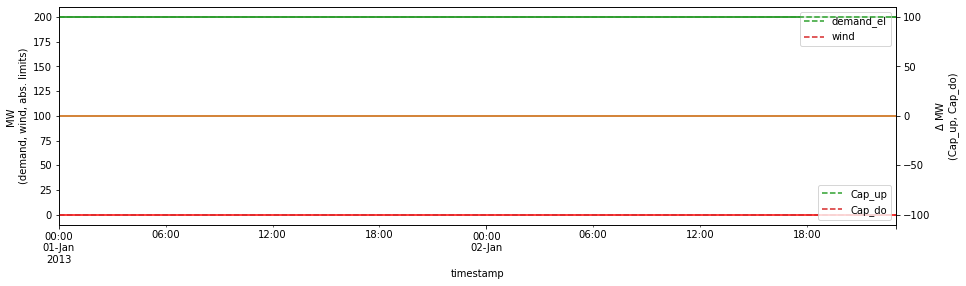

toy-model_constant.png saved.


In [13]:
case = 'constant'

# Base data set
df_data = df_base.copy()

# Plot demand, wind generation and DR capacity limits
fig, ax = plt.subplots(figsize=(15,4))
ax = df_data[['demand_el', 'wind']].plot(ax=ax, drawstyle="steps-post")
# Cap_up and Cap_do only included for proper alignment here
ax = (df_data['demand_el'] + df_data['Cap_up']).plot(ax=ax, drawstyle="steps-post", color="green", label="upper limit")
ax = (df_data['demand_el'] - df_data['Cap_do']).plot(ax=ax, drawstyle="steps-post", color="red", label="lower limit")
ax.legend(loc="upper left", ncol=1)
ax.set_ylabel("MW \n(demand, wind, abs. limits)")

ax = df_data.Cap_up.plot(ax=ax, drawstyle="steps-post", secondary_y=True, linestyle="--")
ax = (df_data.Cap_do*-1).plot(ax=ax, drawstyle="steps-post", secondary_y=True, linestyle="--")
ax.set_yticks(range(-100,150,50))
ax.legend(loc=4, ncol=1)
ax.set_ylabel("$\Delta$ MW \n(Cap_up, Cap_do)")
#plt_dsm.align_yaxis(ax, 0, ax, -100)
plt.show()

if save_figs:
    name = 'toy-model_' + case + '.png'
    fig.savefig('./graphics/' + name)
    plt.close()
    print(name + " saved.")

In [14]:
if few_timesteps:
    df_data = df_base[:9]

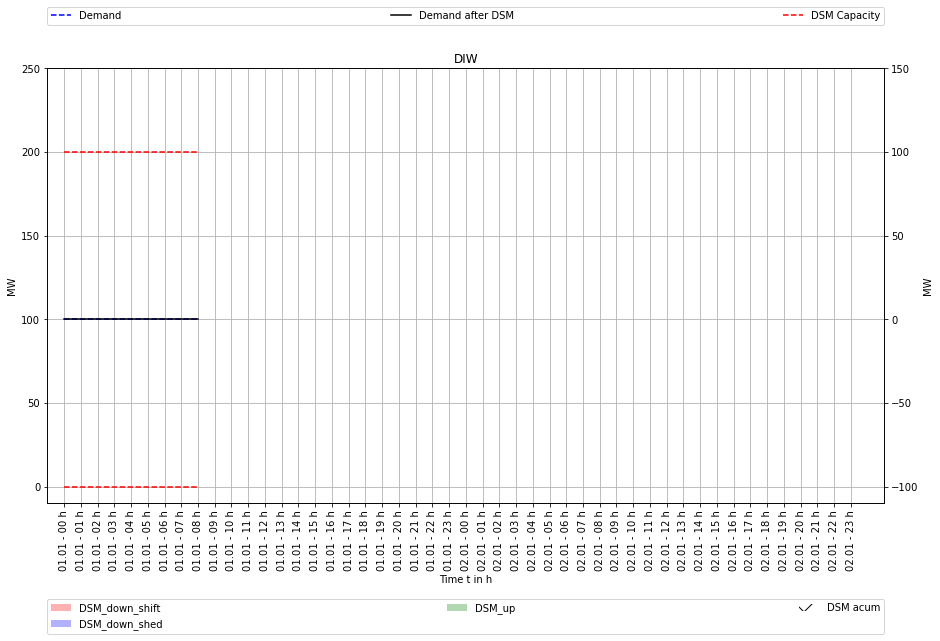

Plot_demand_shift_DIW_constant_2013-01-01.png saved.


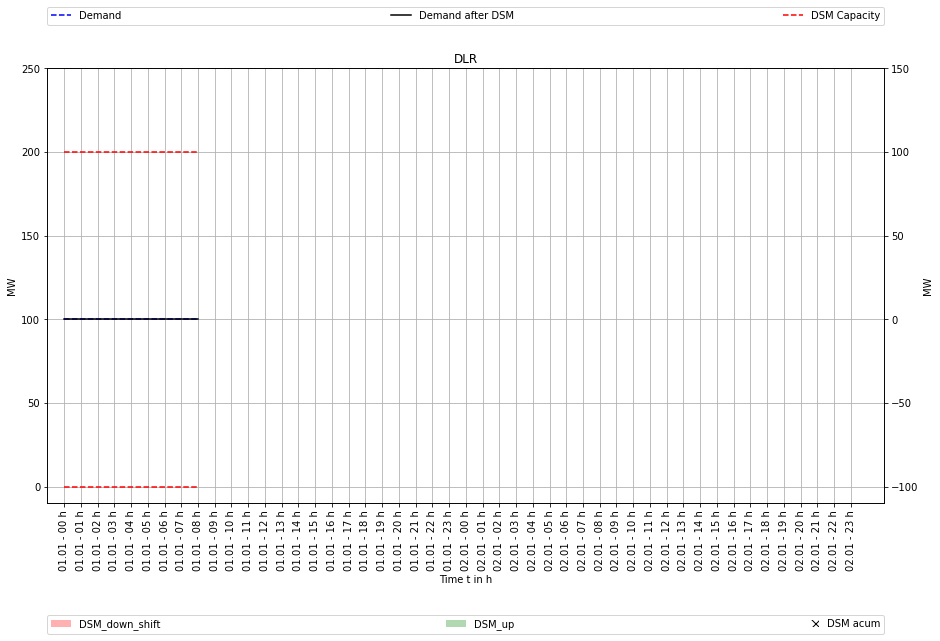

Plot_demand_shift_DLR_constant_2013-01-01.png saved.


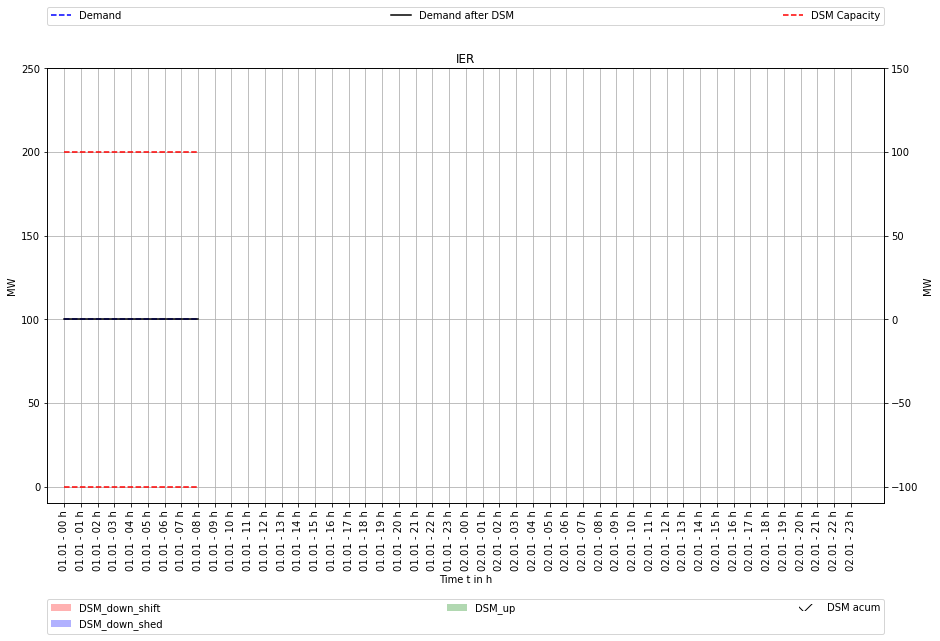

Plot_demand_shift_IER_constant_2013-01-01.png saved.


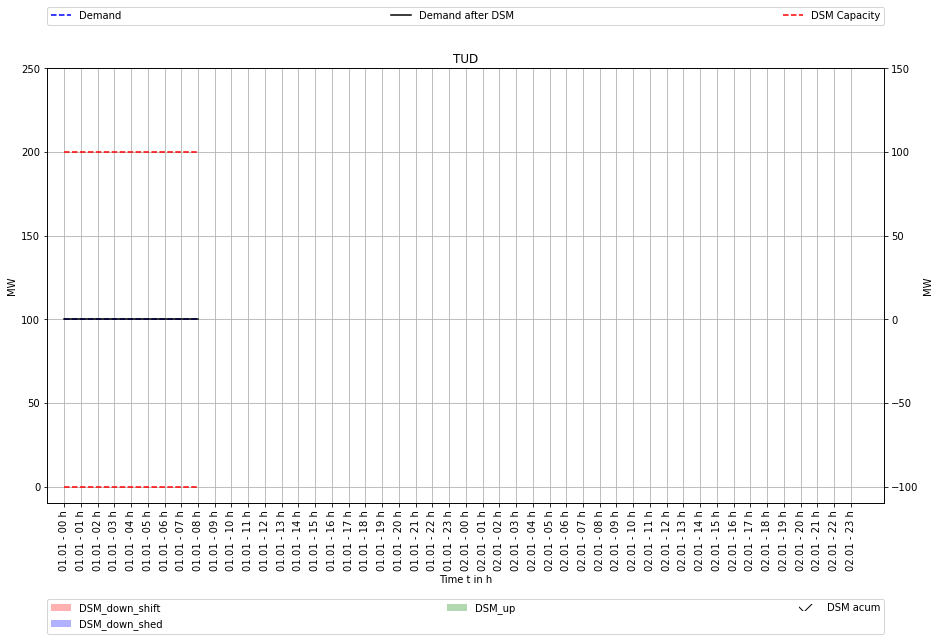

Plot_demand_shift_TUD_constant_2013-01-01.png saved.


In [15]:
# Introduce a dict to store the results of every approach
approach_dict = {}

for approach in approaches:
    approach_dict[approach] = start_model(df_data, timesteps=len(df_data), plot=True, save=save_figs, case=case, 
                                          method='delay', delay_time=4, efficiency=1, approach=approach,
                                          cost_dsm_up=cost_dsm_up, cost_dsm_down_shift=cost_dsm_down_shift, cost_dsm_down_shed=cost_dsm_down_shed,
                                          addition=False, recovery_time_shift=None, recovery_time_shed=4, figsize=(15,8), 
                                          shed_eligibility=True, shed_time=4, n_yearLimit_shed=6,
                                          introduce_second_dsm_unit=introduce_second_dsm_unit,
                                          use_no_shed=use_no_shed, use_shifting_classes=use_shifting_classes)

In [16]:
# Show total values for the timeframe considered
dsm = pd.DataFrame()

for index, df in approach_dict.items():
    dsm[index]  = df[0].abs().sum().round()
    dsm.loc['gen_total', index] = df[0][['wind', 'pv', 'coal1']].sum().sum().round()
    dsm.loc['gen_EE', index] = df[0][['wind', 'pv']].sum().sum().round()

display(dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.style.bar(axis=0 ,color='goldenrod'))

if save_results:
    name = 'results_' + case + '.csv'
    dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.to_csv('./graphics/' + name, sep=';', decimal=',')
    print(name + ' saved.')

,demand_el,dsm_tot,excess,cap_up,cap_do,gen_total,gen_EE,wind,pv,coal1
DIW,900.000000,0.000000,0.000000,900.000000,900.000000,900.000000,900.000000,900.000000,0.000000,0.000000
DLR,900.000000,0.000000,0.000000,900.000000,900.000000,900.000000,900.000000,900.000000,0.000000,0.000000
IER,900.000000,0.000000,0.000000,900.000000,900.000000,900.000000,900.000000,900.000000,0.000000,0.000000
TUD,900.000000,0.000000,0.000000,900.000000,900.000000,900.000000,900.000000,900.000000,0.000000,0.000000


results_constant.csv saved.


### Case 2: Variations in demand and constant generation
Substitute flat demand by introducing one demand peak and one demand drop per day.

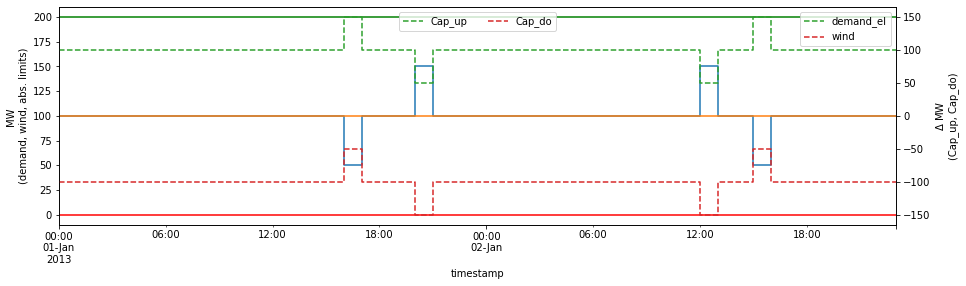

toy-model_dem_variation.png saved.


In [25]:
case = 'dem_variation'

# Data preperation: manipulate demand data
df_data = df_base.copy()
demand = [100] * timesteps

# demand changes
if version == 'simple':
    demand[16:17] = [50]
    demand[20:21] = [150]
    if timesteps > 24:
        demand[36:37] = [150]
        demand[39:40] = [50]

elif version == 'advanced':
    demand[9:13] = [50] * 4
    demand[18:22] = [150] * 4
    if timesteps > 24:
        demand[33:39] = [50] * 6
        demand[42:48] = [150] * 6

df_data['demand_el'] = demand
df_data['Cap_up'] = [100] * timesteps + df_data['Cap_up'] - df_data['demand_el']
df_data['Cap_do'] = [100] * timesteps + df_data['demand_el'] - df_data['Cap_do']

# Plot demand, wind generation and DR capacity limits
fig, ax = plt.subplots(figsize=(15,4))
ax = df_data[['demand_el', 'wind']].plot(ax=ax, drawstyle="steps-post")
# Cap_up and Cap_do only included for proper alignment here
ax = (df_data['demand_el'] + df_data['Cap_up']).plot(ax=ax, drawstyle="steps-post", color="green", label="upper limit")
ax = (df_data['demand_el'] - df_data['Cap_do']).plot(ax=ax, drawstyle="steps-post", color="red", label="lower limit")
ax.legend()
ax.set_ylabel("MW \n(demand, wind, abs. limits)")

ax = df_data.Cap_up.plot(ax=ax, drawstyle="steps-post", secondary_y=True, linestyle="--")
ax = (df_data.Cap_do*-1).plot(ax=ax, drawstyle="steps-post", secondary_y=True, linestyle="--")
ax.set_yticks(range(-150,200,50))
ax.legend(loc=9, ncol=3)
ax.set_ylabel("$\Delta$ MW \n(Cap_up, Cap_do)")
#plt_dsm.align_yaxis(ax, 0, ax, -100)
plt.show()

if save_figs:
    name = 'toy-model_' + case + '.png'
    fig.savefig('./graphics/' + name)
    plt.close()
    print(name + " saved.")

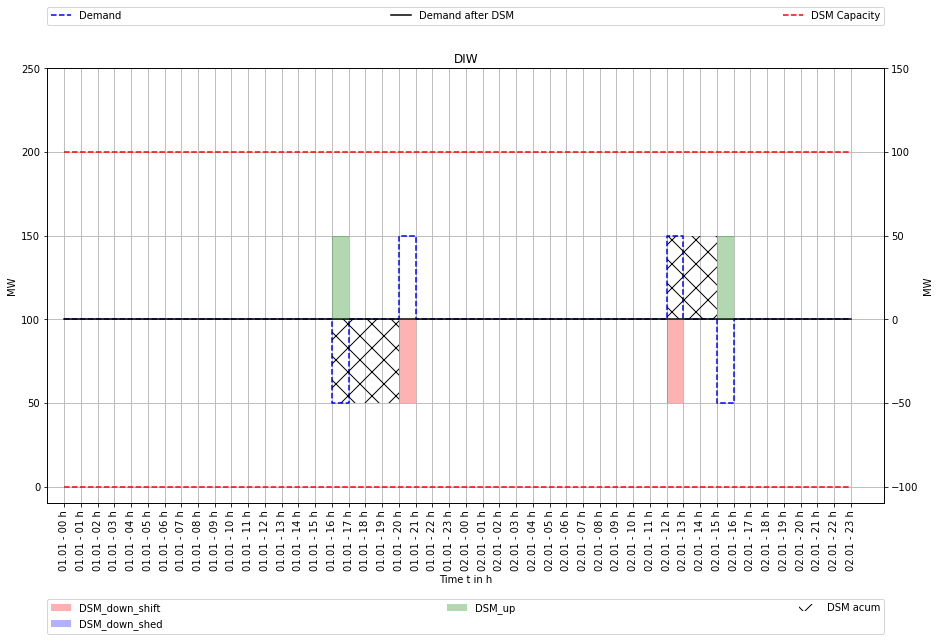

Plot_demand_shift_DIW_dem_variation_2013-01-01.png saved.


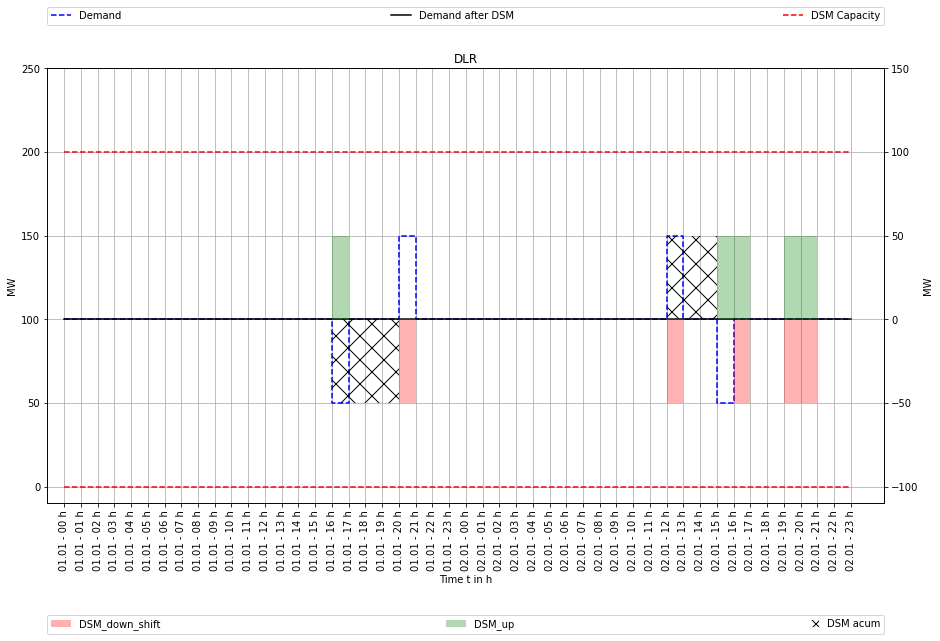

Plot_demand_shift_DLR_dem_variation_2013-01-01.png saved.


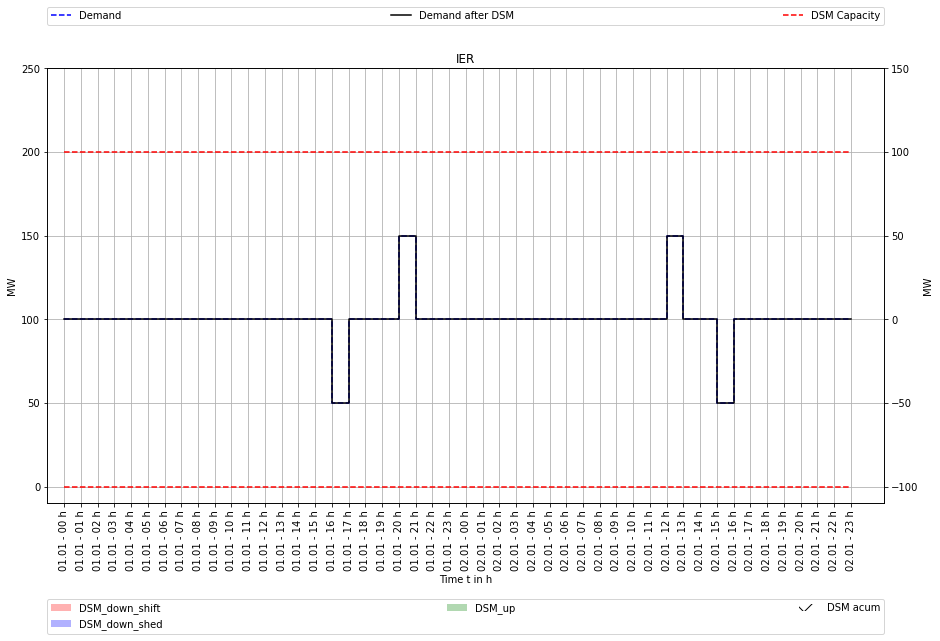

Plot_demand_shift_IER_dem_variation_2013-01-01.png saved.


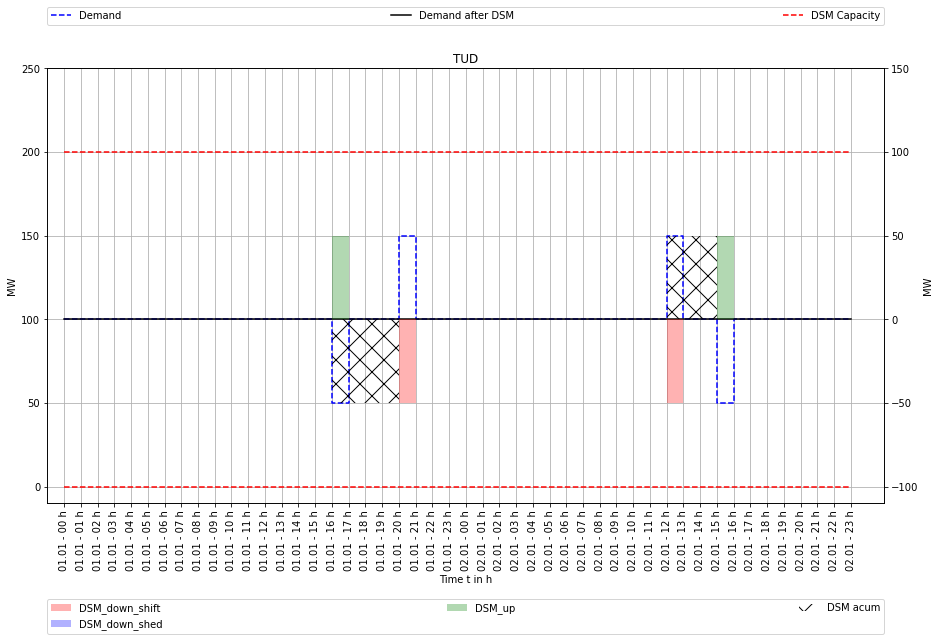

Plot_demand_shift_TUD_dem_variation_2013-01-01.png saved.


In [26]:
# Introduce a dict to store the results of every approach
approach_dict = {}

for approach in approaches:
    approach_dict[approach] = start_model(df_data, timesteps=len(df_data), plot=True, save=save_figs, case=case, 
                                          method='delay', delay_time=4, efficiency=1, approach=approach,
                                          cost_dsm_up=cost_dsm_up, cost_dsm_down_shift=cost_dsm_down_shift, cost_dsm_down_shed=cost_dsm_down_shed,
                                          addition=False, recovery_time_shift=None, recovery_time_shed=4, figsize=(15,8), 
                                          shed_eligibility=True, shed_time=4, n_yearLimit_shed=6,
                                          introduce_second_dsm_unit=introduce_second_dsm_unit,
                                          use_no_shed=use_no_shed, use_shifting_classes=use_shifting_classes)

In [19]:
# Show total values for the timeframe considered
dsm = pd.DataFrame()

for index, df in approach_dict.items():
    dsm[index]  = df[0].abs().sum().round()
    dsm.loc['gen_total', index] = df[0][['wind', 'pv', 'coal1']].sum().sum().round()
    dsm.loc['gen_EE', index] = df[0][['wind', 'pv']].sum().sum().round()

display(dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.style.bar(axis=0 ,color='goldenrod'))

if save_results:
    name = 'results_' + case + '.csv'
    dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.to_csv('./graphics/' + name, sep=';', decimal=',')
    print(name + ' saved.')

,demand_el,dsm_tot,excess,cap_up,cap_do,gen_total,gen_EE,wind,pv,coal1
DIW,4800.000000,200.000000,0.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,0.000000,0.000000
DLR,4800.000000,200.000000,0.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,0.000000,0.000000
IER,4800.000000,0.000000,100.000000,4800.000000,4800.000000,4900.000000,4800.000000,4800.000000,0.000000,100.000000
TUD,4800.000000,100.000000,50.000000,4800.000000,4800.000000,4850.000000,4800.000000,4800.000000,0.000000,50.000000


results_dem_variation.csv saved.


### Case 2b: Increase in demand and constant generation (use case for load shedding)
Substitute flat demand by introducing one demand peak over several hours.

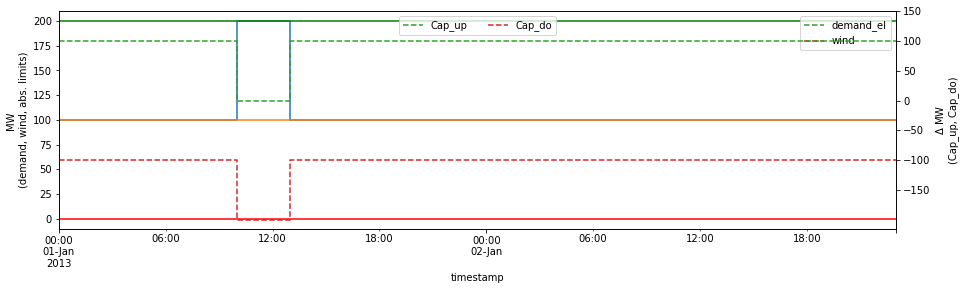

toy-model_dem_variation_shed.png saved.


In [20]:
case = 'dem_variation_shed'

# Data preperation: manipulate demand data
df_data = df_base.copy()
demand = [100] * timesteps

# demand changes
if version == 'simple':
    demand[10:13] = [200] * 3

elif version == 'advanced':
    demand[10:13] = [200] * 3

df_data['demand_el'] = demand
df_data['Cap_up'] = [100] * timesteps + df_data['Cap_up'] - df_data['demand_el']
df_data['Cap_do'] = [100] * timesteps + df_data['demand_el'] - df_data['Cap_do']

# Plot demand, wind generation and DR capacity limits
fig, ax = plt.subplots(figsize=(15,4))
ax = df_data[['demand_el', 'wind']].plot(ax=ax, drawstyle="steps-post")
# Cap_up and Cap_do only included for proper alignment here
ax = (df_data['demand_el'] + df_data['Cap_up']).plot(ax=ax, drawstyle="steps-post", color="green", label="upper limit")
ax = (df_data['demand_el'] - df_data['Cap_do']).plot(ax=ax, drawstyle="steps-post", color="red", label="lower limit")
ax.legend()
ax.set_ylabel("MW \n(demand, wind, abs. limits)")

ax = df_data.Cap_up.plot(ax=ax, drawstyle="steps-post", secondary_y=True, linestyle="--")
ax = (df_data.Cap_do*-1).plot(ax=ax, drawstyle="steps-post", secondary_y=True, linestyle="--")
ax.set_yticks(range(-150,200,50))
ax.legend(loc=9, ncol=3)
ax.set_ylabel("$\Delta$ MW \n(Cap_up, Cap_do)")
#plt_dsm.align_yaxis(ax, 0, ax, -100)
plt.show()

if save_figs:
    name = 'toy-model_' + case + '.png'
    fig.savefig('./graphics/' + name)
    plt.close()
    print(name + " saved.")

> _**NOTE:** A much lower value is used here for shedding costs in order to incentivize load shedding._

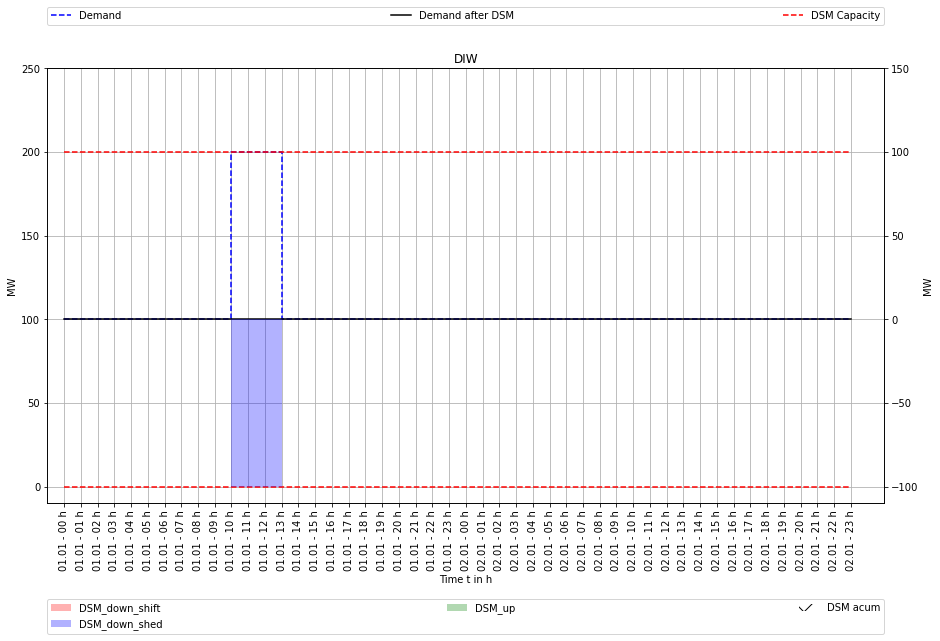

Plot_demand_shift_DIW_dem_variation_shed_2013-01-01.png saved.


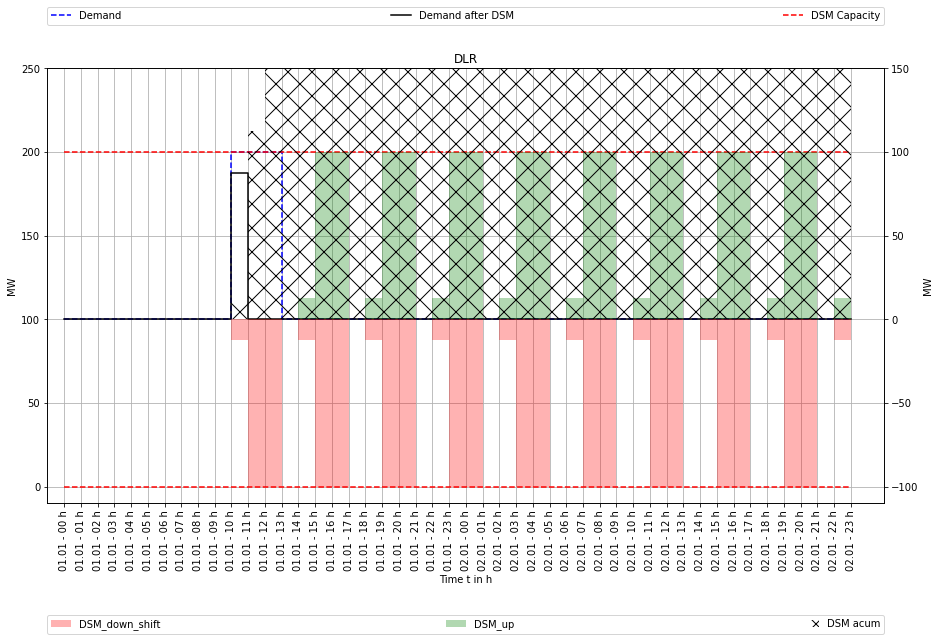

Plot_demand_shift_DLR_dem_variation_shed_2013-01-01.png saved.


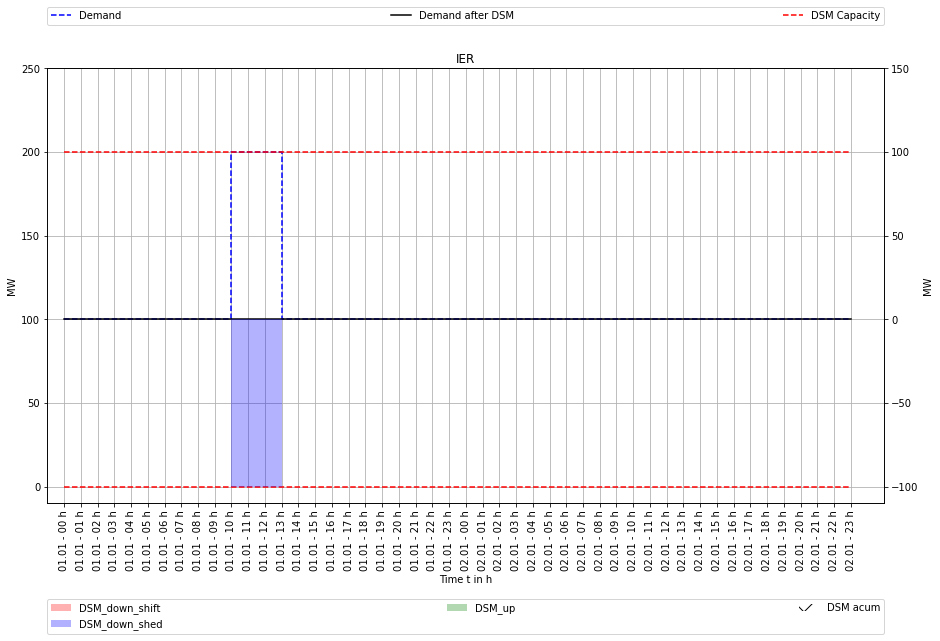

Plot_demand_shift_IER_dem_variation_shed_2013-01-01.png saved.


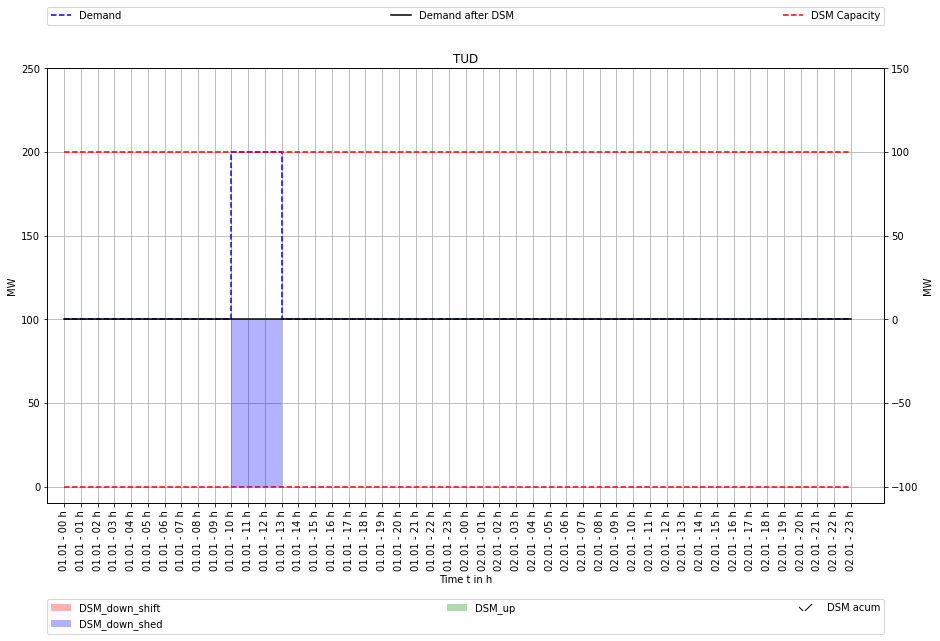

Plot_demand_shift_TUD_dem_variation_shed_2013-01-01.png saved.


In [21]:
# Introduce a dict to store the results of every approach
approach_dict = {}

for approach in approaches:
    approach_dict[approach] = start_model(df_data, timesteps=len(df_data), plot=True, save=save_figs, case=case, 
                                          method='delay', delay_time=4, efficiency=1, approach=approach,
                                          cost_dsm_up=cost_dsm_up, cost_dsm_down_shift=cost_dsm_down_shift, cost_dsm_down_shed=0.1,
                                          addition=False, recovery_time_shift=None, recovery_time_shed=4, figsize=(15,8), 
                                          shed_eligibility=True, shed_time=4, n_yearLimit_shed=6,
                                          introduce_second_dsm_unit=introduce_second_dsm_unit,
                                          use_no_shed=use_no_shed, use_shifting_classes=use_shifting_classes)

In [22]:
# Show total values for the timeframe considered
dsm = pd.DataFrame()

for index, df in approach_dict.items():
    dsm[index]  = df[0].abs().sum().round()
    dsm.loc['gen_total', index] = df[0][['wind', 'pv', 'coal1']].sum().sum().round()
    dsm.loc['gen_EE', index] = df[0][['wind', 'pv']].sum().sum().round()

display(dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.style.bar(axis=0 ,color='goldenrod'))

if save_results:
    name = 'results_' + case + '.csv'
    dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.to_csv('./graphics/' + name, sep=';', decimal=',')
    print(name + ' saved.')

,demand_el,dsm_tot,excess,cap_up,cap_do,gen_total,gen_EE,wind,pv,coal1
DIW,5100.000000,0.000000,0.000000,4500.000000,5100.000000,4800.000000,4800.000000,4800.000000,0.000000,0.000000
DLR,5100.000000,212.000000,0.000000,4500.000000,5100.000000,4888.000000,4800.000000,4800.000000,0.000000,88.000000
IER,5100.000000,0.000000,0.000000,4500.000000,5100.000000,4800.000000,4800.000000,4800.000000,0.000000,0.000000
TUD,5100.000000,0.000000,0.000000,4500.000000,5100.000000,4800.000000,4800.000000,4800.000000,0.000000,0.000000


results_dem_variation_shed.csv saved.


### Case 3: Variations in generation and constant demand
Introduce wind peaks and wind drops of different length

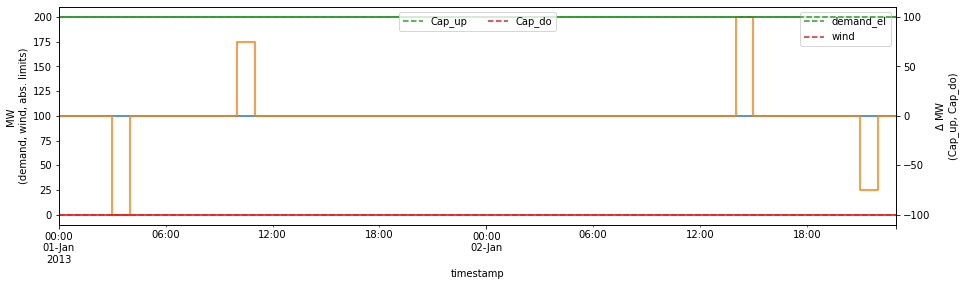

toy-model_gen_variation.png saved.


In [23]:
case = 'gen_variation'

# Data preperation: manipulate wind data
df_data = df_base.copy()
wind = [100] * timesteps

# wind changes
if version == 'simple':
    wind[3:4] = [0]
    wind[10:11] = [175]
    if timesteps > 24:
        wind[38:39] = [200]
        wind[45:46] = [25]

if version == 'advanced':
    wind[3:7] = [0] * 4
    wind[21:22] = [175]
    if timesteps > 24:
        wind[38:42] = [200] * 4
        wind[27:28] = [25]

df_data['wind'] = wind

# Plot demand, wind generation and DR capacity limits
fig, ax = plt.subplots(figsize=(15,4))
ax = df_data[['demand_el', 'wind']].plot(ax=ax, drawstyle="steps-post")
# Cap_up and Cap_do only included for proper alignment here
ax = (df_data['demand_el'] + df_data['Cap_up']).plot(ax=ax, drawstyle="steps-post", color="green", label="upper limit")
ax = (df_data['demand_el'] - df_data['Cap_do']).plot(ax=ax, drawstyle="steps-post", color="red", label="lower limit")
ax.legend()
ax.set_ylabel("MW \n(demand, wind, abs. limits)")

ax = df_data.Cap_up.plot(ax=ax, drawstyle="steps-post", secondary_y=True, linestyle="--")
ax = (df_data.Cap_do*-1).plot(ax=ax, drawstyle="steps-post", secondary_y=True, linestyle="--")
ax.set_yticks(range(-100,150,50))
ax.legend(loc=9, ncol=3)
ax.set_ylabel("$\Delta$ MW \n(Cap_up, Cap_do)")
#plt_dsm.align_yaxis(ax, 0, ax, -100)
plt.show()

if save_figs:
    name = 'toy-model_' + case + '.png'
    fig.savefig('./graphics/' + name)
    plt.close()
    print(name + " saved.")

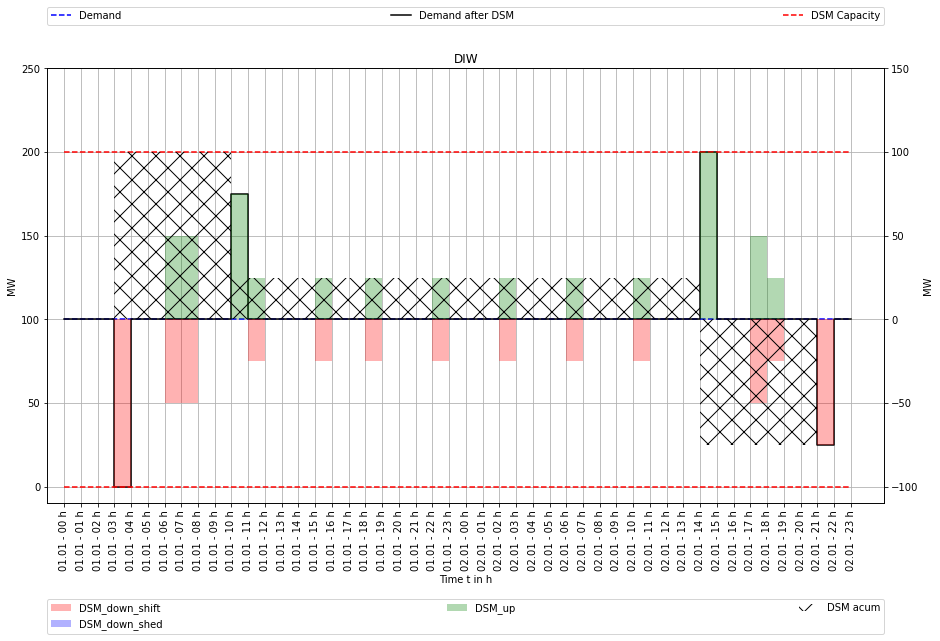

Plot_demand_shift_DIW_gen_variation_2013-01-01.png saved.


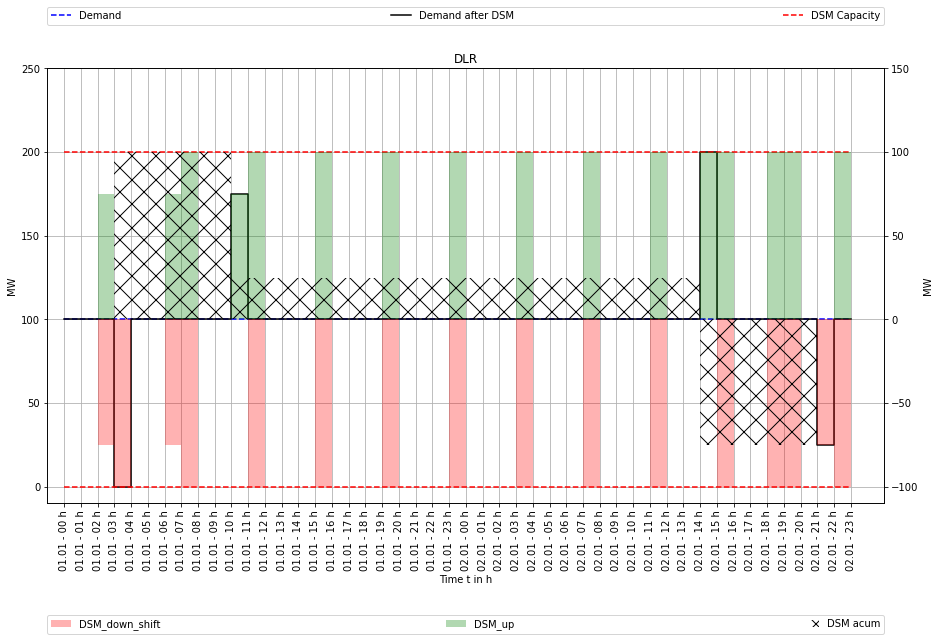

Plot_demand_shift_DLR_gen_variation_2013-01-01.png saved.


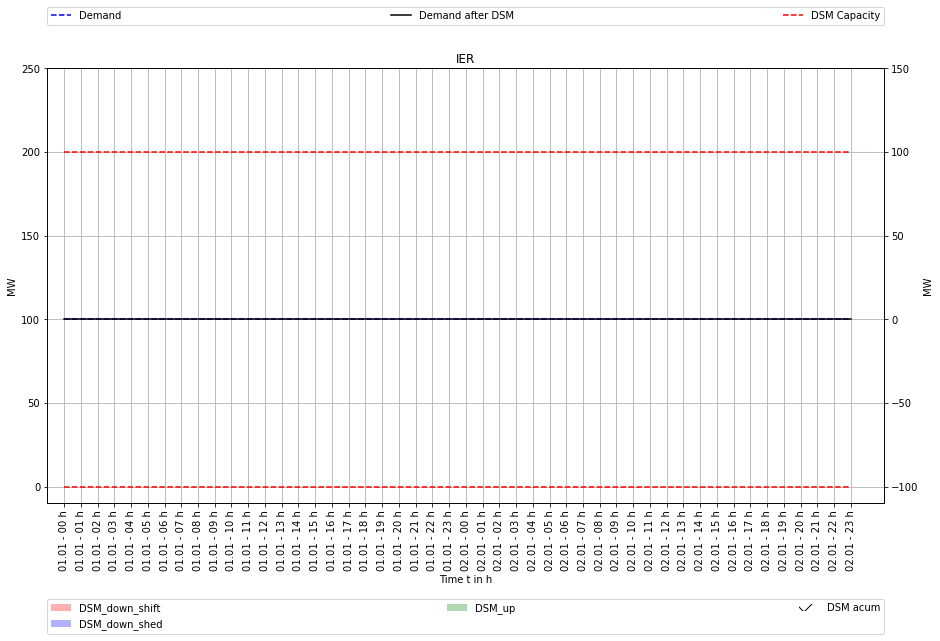

Plot_demand_shift_IER_gen_variation_2013-01-01.png saved.


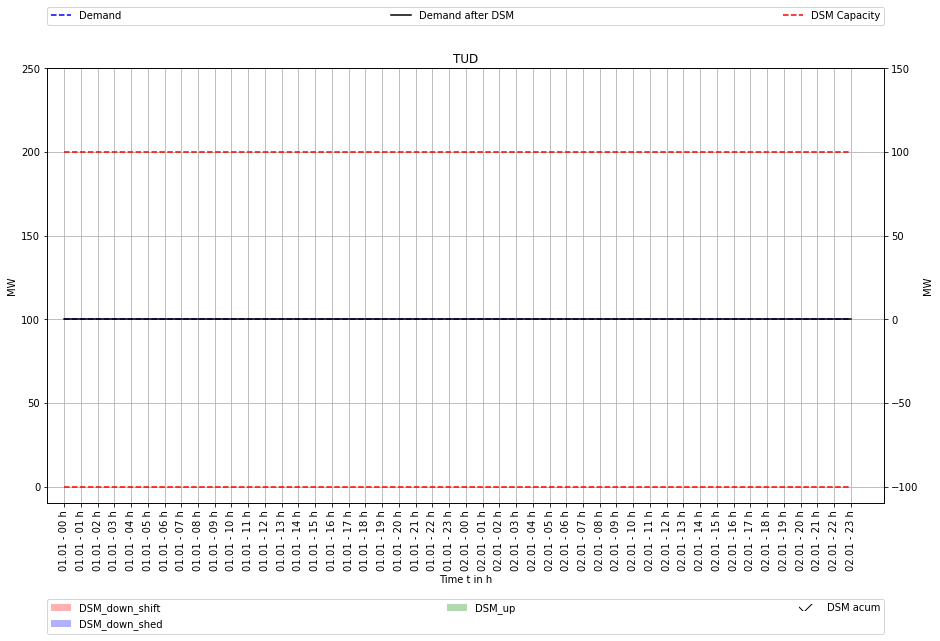

Plot_demand_shift_TUD_gen_variation_2013-01-01.png saved.


In [24]:
# Introduce a dict to store the results of every approach
approach_dict = {}

for approach in approaches:
    approach_dict[approach] = start_model(df_data, timesteps=len(df_data), plot=True, save=save_figs, case=case, 
                                          method='delay', delay_time=4, efficiency=1, approach=approach,
                                          cost_dsm_up=cost_dsm_up, cost_dsm_down_shift=cost_dsm_down_shift, cost_dsm_down_shed=cost_dsm_down_shed,
                                          addition=False, recovery_time_shift=None, recovery_time_shed=4, figsize=(15,8), 
                                          shed_eligibility=True, shed_time=4, n_yearLimit_shed=6,
                                          introduce_second_dsm_unit=introduce_second_dsm_unit,
                                          use_no_shed=use_no_shed, use_shifting_classes=use_shifting_classes)

In [25]:
# Show total values for the timeframe considered
dsm = pd.DataFrame()

for index, df in approach_dict.items():
    dsm[index]  = df[0].abs().sum().round()
    dsm.loc['gen_total', index] = df[0][['wind', 'pv', 'coal1']].sum().sum().round()
    dsm.loc['gen_EE', index] = df[0][['wind', 'pv']].sum().sum().round()

display(dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.style.bar(axis=0 ,color='goldenrod'))

if save_results:
    name = 'results_' + case + '.csv'
    dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.to_csv('./graphics/' + name, sep=';', decimal=',')
    print(name + ' saved.')

,demand_el,dsm_tot,excess,cap_up,cap_do,gen_total,gen_EE,wind,pv,coal1
DIW,4800.000000,350.000000,0.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,0.000000,0.000000
DLR,4800.000000,350.000000,0.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,0.000000,0.000000
IER,4800.000000,0.000000,175.000000,4800.000000,4800.000000,4975.000000,4800.000000,4800.000000,0.000000,175.000000
TUD,4800.000000,0.000000,175.000000,4800.000000,4800.000000,4975.000000,4800.000000,4800.000000,0.000000,175.000000


results_gen_variation.csv saved.


### Case 4: Variations in demand and generation
Demand and wind variations are introduced by forming a combination of cases 2 and 3.

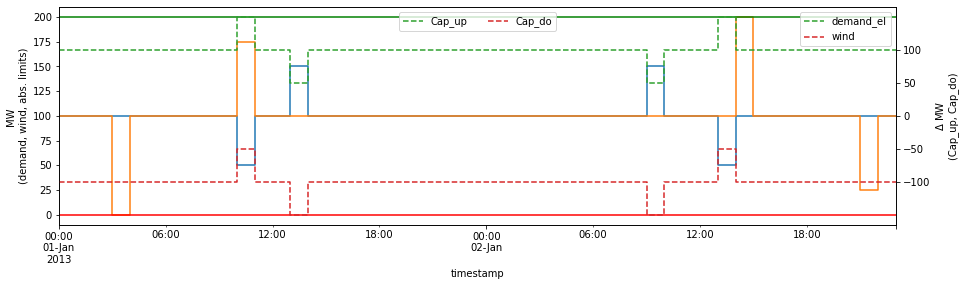

toy-model_combined_variation.png saved.


In [26]:
case = 'combined_variation'

# Data preperation: manipulate demand and wind data
df_data = df_base.copy()
demand = [100] * timesteps
wind = [100] * timesteps

if version == 'simple':
    # demand changes
    demand[10:11] = [50]
    demand[13:14] = [150]
    if timesteps > 24:
        demand[33:34] = [150]
        demand[37:38] = [50]
    
    # wind changes
    wind[3:4] = [0]
    wind[10:11] = [175]
    if timesteps > 24:
        wind[38:39] = [200]
        wind[45:46] = [25]

elif version == 'advanced':
    # demand changes
    demand[9:13] = [50] * 4
    demand[18:22] = [150] * 4
    if timesteps > 24:
        demand[33:39] = [50] * 6
        demand[42:48] = [150] * 6
        
    # wind changes
    wind[3:7] = [0] * 4
    wind[21:22] = [175]
    if timesteps > 24:
        wind[38:42] = [200] * 4
        wind[27:28] = [25]

df_data['demand_el'] = demand
df_data['Cap_up'] = [100] * timesteps + df_data['Cap_up'] - df_data['demand_el']
df_data['Cap_do'] = [100] * timesteps + df_data['demand_el'] - df_data['Cap_do']
df_data['wind'] = wind

# Plot demand, wind generation and DR capacity limits
fig, ax = plt.subplots(figsize=(15,4))
ax = df_data[['demand_el', 'wind']].plot(ax=ax, drawstyle="steps-post")
# Cap_up and Cap_do only included for proper alignment here
ax = (df_data['demand_el'] + df_data['Cap_up']).plot(ax=ax, drawstyle="steps-post", color="green", label="upper limit")
ax = (df_data['demand_el'] - df_data['Cap_do']).plot(ax=ax, drawstyle="steps-post", color="red", label="lower limit")
ax.legend()
ax.set_ylabel("MW \n(demand, wind, abs. limits)")

ax = df_data.Cap_up.plot(ax=ax, drawstyle="steps-post", secondary_y=True, linestyle="--")
ax = (df_data.Cap_do*-1).plot(ax=ax, drawstyle="steps-post", secondary_y=True, linestyle="--")
ax.set_yticks(range(-100,150,50))
ax.legend(loc=9, ncol=3)
ax.set_ylabel("$\Delta$ MW \n(Cap_up, Cap_do)")
#plt_dsm.align_yaxis(ax, 0, ax, -100)
plt.show()

if save_figs:
    name = 'toy-model_' + case + '.png'
    fig.savefig('./graphics/' + name)
    plt.close()
    print(name + " saved.")

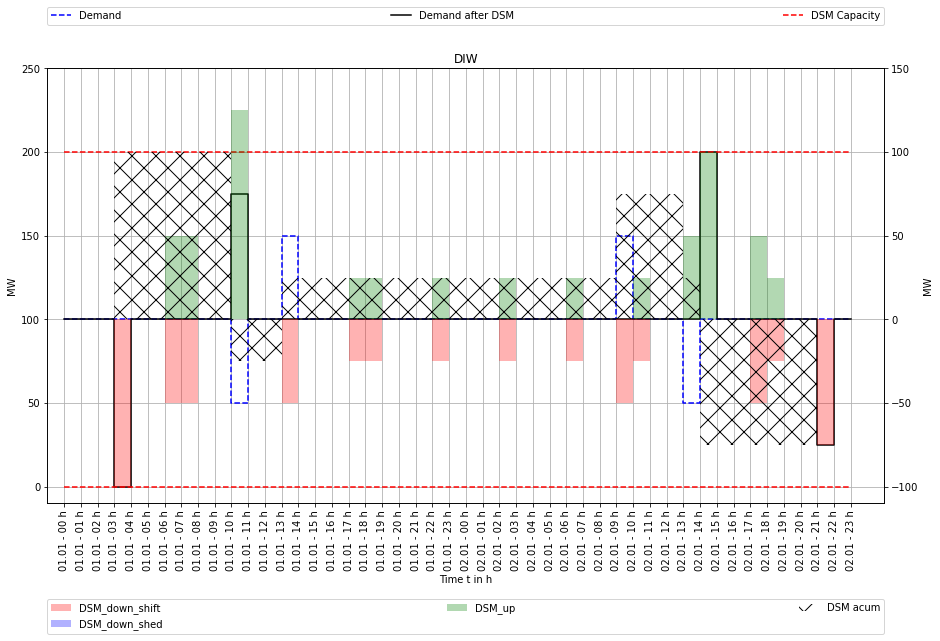

Plot_demand_shift_DIW_combined_variation_2013-01-01.png saved.


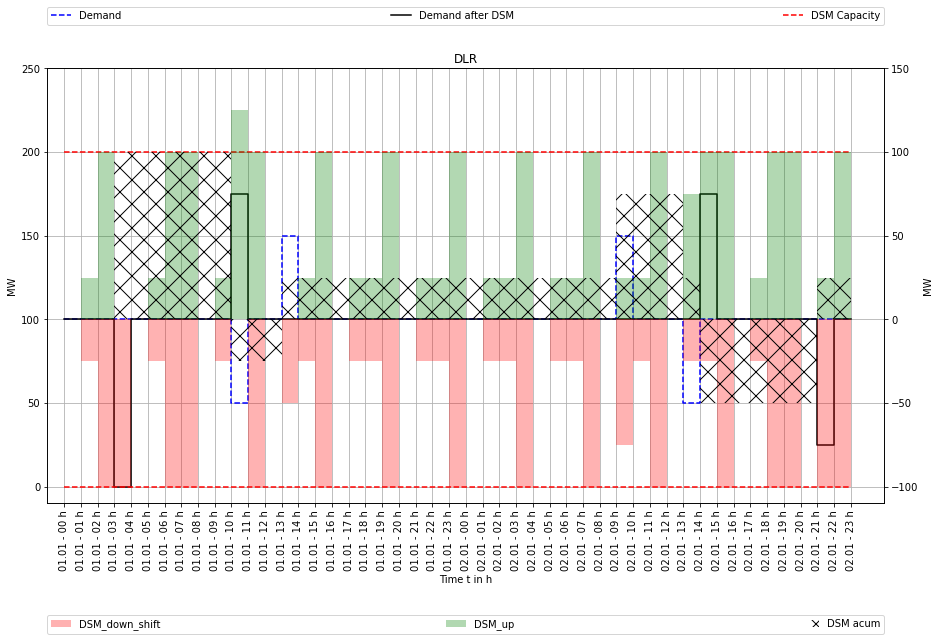

Plot_demand_shift_DLR_combined_variation_2013-01-01.png saved.


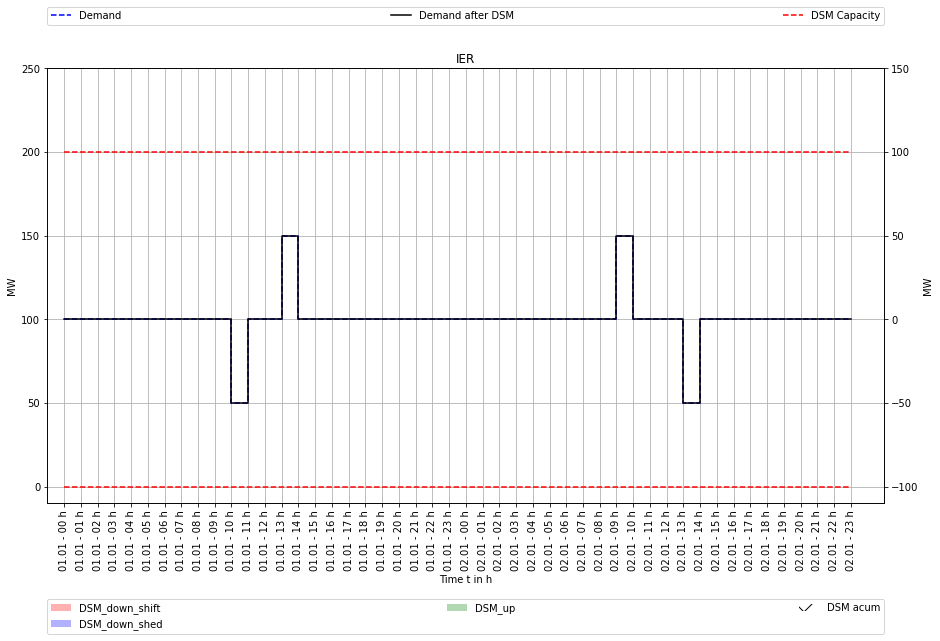

Plot_demand_shift_IER_combined_variation_2013-01-01.png saved.


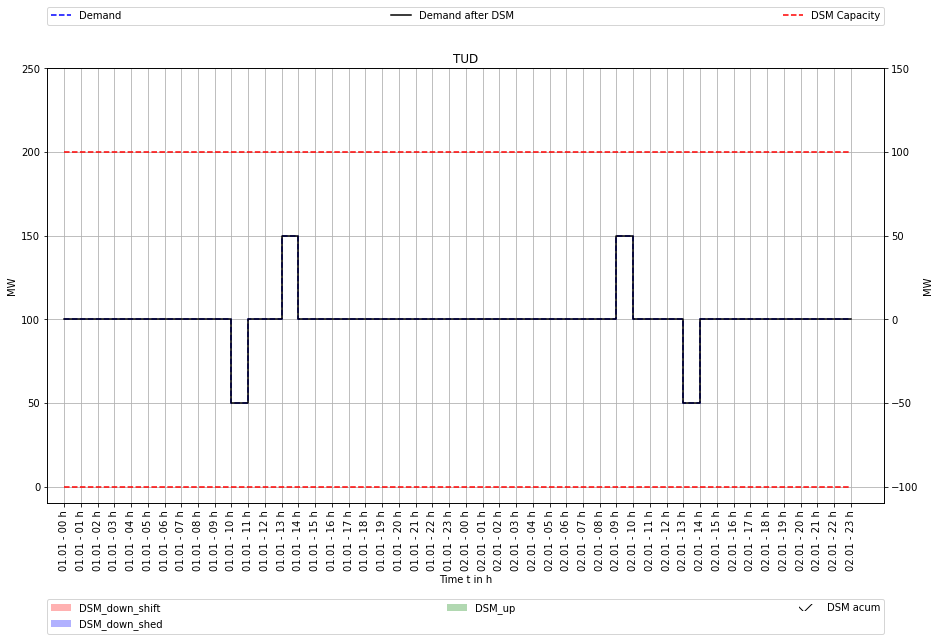

Plot_demand_shift_TUD_combined_variation_2013-01-01.png saved.


In [27]:
# Introduce a dict to store the results of every approach
approach_dict = {}

for approach in approaches:
    approach_dict[approach] = start_model(df_data, timesteps=len(df_data), plot=True, save=save_figs, case=case, 
                                          method='delay', delay_time=4, efficiency=1, approach=approach,
                                          cost_dsm_up=cost_dsm_up, cost_dsm_down_shift=cost_dsm_down_shift, cost_dsm_down_shed=cost_dsm_down_shed,
                                          addition=False, recovery_time_shift=None, recovery_time_shed=4, figsize=(15,8), 
                                          shed_eligibility=True, shed_time=4, n_yearLimit_shed=6,
                                          introduce_second_dsm_unit=introduce_second_dsm_unit,
                                          use_no_shed=use_no_shed, use_shifting_classes=use_shifting_classes)

In [28]:
# Show total values for the timeframe considered
dsm = pd.DataFrame()

for index, df in approach_dict.items():
    dsm[index]  = df[0].abs().sum().round()
    dsm.loc['gen_total', index] = df[0][['wind', 'pv', 'coal1']].sum().sum().round()
    dsm.loc['gen_EE', index] = df[0][['wind', 'pv']].sum().sum().round()

display(dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.style.bar(axis=0 ,color='goldenrod'))

if save_results:
    name = 'results_' + case + '.csv'
    dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.to_csv('./graphics/' + name, sep=';', decimal=',')
    print(name + ' saved.')

,demand_el,dsm_tot,excess,cap_up,cap_do,gen_total,gen_EE,wind,pv,coal1
DIW,4800.000000,550.000000,0.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,0.000000,0.000000
DLR,4800.000000,525.000000,25.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,0.000000,0.000000
IER,4800.000000,0.000000,275.000000,4800.000000,4800.000000,5075.000000,4800.000000,4800.000000,0.000000,275.000000
TUD,4800.000000,0.000000,275.000000,4800.000000,4800.000000,5075.000000,4800.000000,4800.000000,0.000000,275.000000


results_combined_variation.csv saved.


## More realistic data setting
Input data from the aggregation_example.ipynb written by Julian Endres is used, see: https://github.com/windnode/SinkDSM_example/blob/master/aggregation_example.ipynb

### Initial parameter settings
* Determine model settings (timesteps)
* Only consider project methods (other example covering different aggregation levels is not considered here)

In [29]:
case = 'realistic'

project = 'methods'
start_model = '2013-03-01 00:00:00+0100'

# Set time range for model (further possible values are uncommented)
#timesteps_model = 'all'
timesteps_model = 24 * 7
#timesteps_model = '2013-03-03 00:00:00'

# Print model start and end information
print('Model begins at:')
print(start_model)

if timesteps_model == 'all':
    print('covers {} timesteps'.format(timesteps_model))
elif isinstance(timesteps_model, int):
    print('ends after {} timesteps'.format(timesteps_model))
elif isinstance(timesteps_model, str):
    print('ends at: {}'.format(timesteps_model))

Model begins at:
2013-03-01 00:00:00+0100
ends after 168 timesteps


### Read in input data

In [30]:
# Input directory and file
input_directory = 'data/{}/'.format(project)
input_file = 'scaled_data_2.csv'
folder = input_directory + input_file
filename_data = os.path.join(os.path.dirname('__file__'), folder)

# Read in data and do timezone adjustments
data = pd.read_csv(filename_data,
                   sep=";",
                   decimal=',',
                   encoding='utf-8',
                   parse_dates=True,
                   date_parser=pd.to_datetime)
data.sort_index(inplace=True)

tz = 'Europe/Berlin'
data.set_index('timestamp', inplace=True)
data.index = pd.to_datetime(data.index, utc=True).tz_convert(tz)
data.rename(columns={'cap_up':'Cap_up', 'cap_do': 'Cap_do'}, inplace=True)

### Extract model results for realistic toy model
Run method defined above

In [31]:
dict_df_model, datetimeindex, dict_meta_model = create_realistic_example(data, start_model, timesteps_model, approaches,
                                                                         plot=True, save=save_figs, method='delay', 
                                                                         delay_time=4, efficiency=1, 
                                                                         cost_dsm_up=cost_dsm_up, cost_dsm_down_shift=cost_dsm_down_shift, cost_dsm_down_shed=cost_dsm_down_shed,
                                                                         addition=False, recovery_time_shift=None, recovery_time_shed=4, figsize=(15,8), 
                                                                         shed_eligibility=True, shed_time=4, n_yearLimit_shed=6)

### Define presets and do data preparation for output plots
* Define some settings in order to create another kind of visualization for demand response results.
* Transfer the data in such a shape that it can easily be visualized.

In [32]:
# Presets
figure_size = (15,6)

# start of plot
start = datetimeindex[0]

# plotted time range
timesteps = 24 * 3 + 3 #*31
steps = pd.date_range(start, periods=timesteps, freq='H', tz='Europe/Berlin') # stepsize

plot_style = 'normal'

color=['teal','goldenrod','grey','coral','olive','orchid', 'silver', 'seagreen', 'slateblue']
drawstyle= {'scientific':{'step':'pre','drawstyle':'steps-post'},'normal':{'step':None,'drawstyle':None }}
ds = drawstyle[plot_style]

tz = 'Europe/Berlin'
end = steps[-1]

# Show some logging info
print('start: {}'.format(start))
print('end:   {}'.format(end))
print('Approaches evaluated:')
print([keys for keys in dict_df_model.keys()])

start: 2013-03-01 00:00:00+01:00
end:   2013-03-04 02:00:00+01:00
Approaches evaluated:
['DIW', 'DLR', 'IER', 'TUD']


### Show and plot the results
* Show total values per approach
* Show plots in order to visually inspect differences

In [33]:
# Show total values for the timeframe considered
dsm = pd.DataFrame()

for index, df in dict_df_model.items():
    dsm[index]  =df.abs().sum().round()
    dsm.loc['gen_total', index] = df[['wind', 'pv', 'coal1']].sum().sum().round()
    dsm.loc['gen_EE', index] = df[['wind', 'pv']].sum().sum().round()

display(dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.style.bar(axis=0 ,color='goldenrod'))

if save_results:
    name = 'results_' + case + '.csv'
    dsm.loc[['demand_el','dsm_tot','excess',
                 'cap_up', 'cap_do',
                 'gen_total','gen_EE',
                 'wind', 'pv', 'coal1']].T.to_csv('./graphics/' + name, sep=';', decimal=',')
    print(name + ' saved.')

,demand_el,dsm_tot,excess,cap_up,cap_do,gen_total,gen_EE,wind,pv,coal1
DIW,1241.000000,222.000000,107.000000,831.000000,382.000000,1347.000000,901.000000,602.000000,299.000000,447.000000
DLR,1241.000000,173.000000,126.000000,831.000000,382.000000,1377.000000,901.000000,602.000000,299.000000,476.000000
IER,1241.000000,0.000000,218.000000,831.000000,382.000000,1458.000000,901.000000,602.000000,299.000000,558.000000
TUD,1241.000000,35.000000,200.000000,831.000000,382.000000,1441.000000,901.000000,602.000000,299.000000,540.000000


results_realistic.csv saved.


In [34]:
dict_df_model["DIW"]

,coal1,wind,pv,excess,shortage,demand_dsm,dsm_do_shift,dsm_do_shed,dsm_up,dsm_tot,dsm_acum,demand_el,cap_up,cap_do
2013-03-01 00:00:00+01:00,3.154218,2.021600,0.0,0.000000,0.0,5.175817,0.00000,0.0,0.0,0.00000,0.000000e+00,5.175817,1.483205,2.631384
2013-03-01 01:00:00+01:00,3.155166,2.364535,0.0,0.000000,0.0,5.519701,0.00000,0.0,0.0,0.00000,0.000000e+00,5.519701,1.483205,2.856022
2013-03-01 02:00:00+01:00,1.829063,2.649504,0.0,0.000000,0.0,4.478567,0.00000,0.0,0.0,0.00000,0.000000e+00,4.478567,1.483205,2.097226
2013-03-01 03:00:00+01:00,0.562145,2.965299,0.0,0.000000,0.0,3.527444,0.00000,0.0,0.0,0.00000,0.000000e+00,3.527444,1.483205,1.538215
2013-03-01 04:00:00+01:00,0.295661,2.808324,0.0,0.000000,0.0,3.103985,0.00000,0.0,0.0,0.00000,0.000000e+00,3.103985,1.483205,1.504080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-07 19:00:00+01:00,0.000000,8.663961,0.0,0.000000,0.0,8.663961,0.50353,0.0,0.0,0.50353,-8.881784e-16,9.167491,11.508306,1.970046
2013-03-07 20:00:00+01:00,0.000000,11.726027,0.0,1.299419,0.0,10.426608,0.00000,0.0,0.0,0.00000,-8.881784e-16,10.426608,11.087995,1.885259
2013-03-07 21:00:00+01:00,0.000000,15.412145,0.0,6.458277,0.0,8.953868,0.00000,0.0,0.0,0.00000,-8.881784e-16,8.953868,11.320483,1.978005
2013-03-07 22:00:00+01:00,0.000000,17.213182,0.0,8.471721,0.0,8.741460,0.00000,0.0,0.0,0.00000,-8.881784e-16,8.741460,1.483205,1.606938


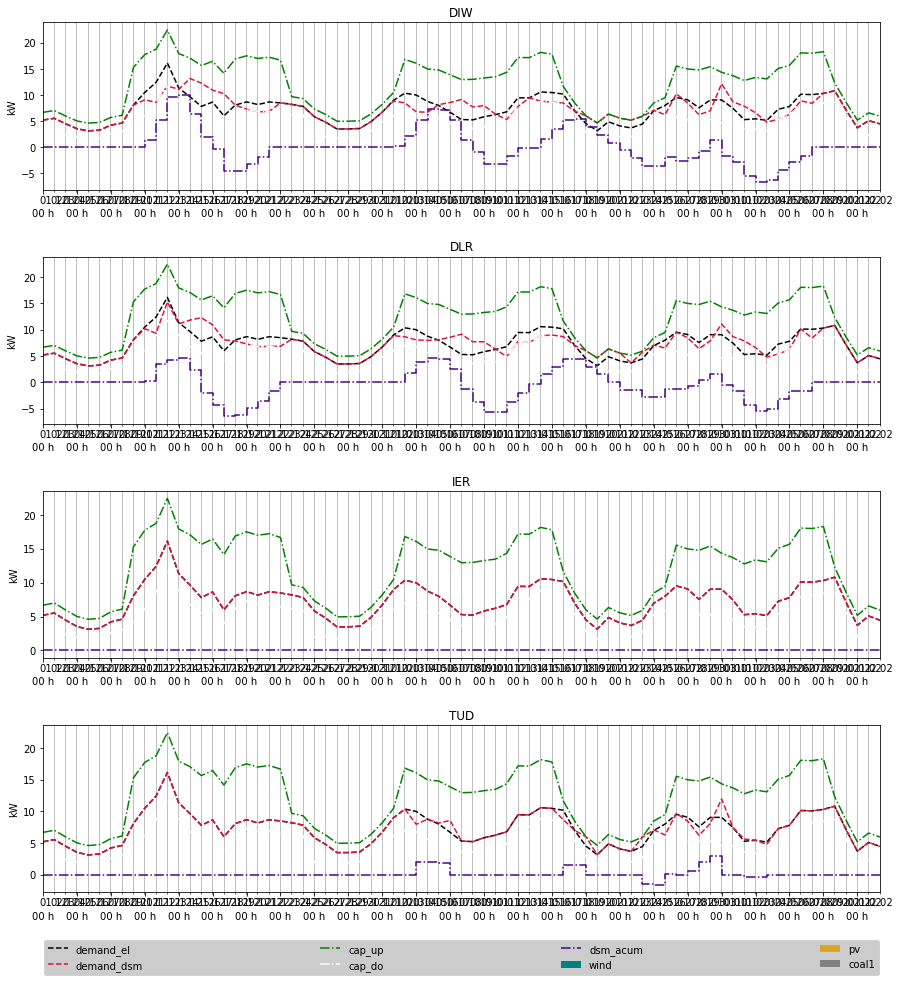

realistic_example_plot.png saved.


In [35]:
column = ['wind', 'pv', 'coal1']
plots = len([s for s in dict_df_model.keys()])
fig_all, ax = plt.subplots(max(plots,2),1,figsize=(15,plots*4))

i=0
keys=[]
for _, (key, df) in enumerate(dict_df_model.items()):
    
    keys.append(key)

    ax[i].set_title(key)

    # Area plot generation
    upper = 0
    lower = 0
    for gen, col in enumerate(df[column]):
        upper += df.copy().loc[steps, col]
        upper.name = col
        ax[i].fill_between(steps, lower, upper, step=ds['step'], facecolor=color[gen], label=col)
        lower = upper.copy()

    # plot demand
    ax[i] = df.loc[steps,'demand_el'].plot(ax=ax[i], drawstyle=ds['drawstyle'], style='--', color='black')
    ax[i] = df.loc[steps,'demand_dsm'].plot(ax=ax[i], drawstyle=ds['drawstyle'], style='--', color='crimson')

    # calc & plot upper capacity
    cap_up = df.loc[steps,'demand_el'] + df.loc[steps,'cap_up']
    cap_up.name='cap_up'
    ax[i] = cap_up.plot(ax=ax[i], drawstyle=ds['drawstyle'], style='-.', color='green')

    # calc & plot lower capacity
    cap_down = df.loc[steps,'demand_el'] - df.loc[steps,'cap_do']
    cap_down.name='cap_do'
    ax[i] = cap_down.plot(ax=ax[i], drawstyle=ds['drawstyle'], style='-.', color='white')


    ax[i] = df.loc[steps, 'dsm_acum'].plot(ax=ax[i], drawstyle='steps-post', style='-.', color='indigo')

    ax[i].set_ylabel('kW')
    ax[i].set_xticks(pd.date_range(start=start, periods=timesteps/3, freq='3H', tz=tz))
    ax[i].xaxis.set_minor_locator(mdates.DayLocator(tz = df.index.tz))
    ax[i].xaxis.set_minor_formatter(mdates.DateFormatter('%d.%m', tz=df.index.tz))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('\n%H h', tz=df.index.tz)) 
    ax[i].xaxis.grid(True, which="minor")
    ax[i].xaxis.grid(False, which="major")
    #ax[i].set_facecolor='white'


    i+=1

handles, labels = ax[i-1].get_legend_handles_labels()
ax[i-1].legend(labels,
             bbox_to_anchor=(0., -.5, 1., .102),
             loc=3, ncol=4,
             mode="expand",
             borderaxespad=0.1,
             facecolor='silver')
fig_all.subplots_adjust(hspace = 0.4)
plt.show()

if save_figs:
    name = 'realistic_example_plot.png'
    fig_all.savefig('./graphics/' + name, bbox_inches='tight')
    print(name + ' saved.')

### Compare energy on hold, capacity limits as well as activations up / down
* Energy on hold: The amount of energy that has to be compensated by load shifts in the other direction again. &rarr; A positive value means that upwards shifts are necessary for balancing.
* Capacity limits: The capacity available for upwards resp. downwards shifts. &rarr; Identical since this is set as an input parameter.
* Activations in upwards / downwards direction.

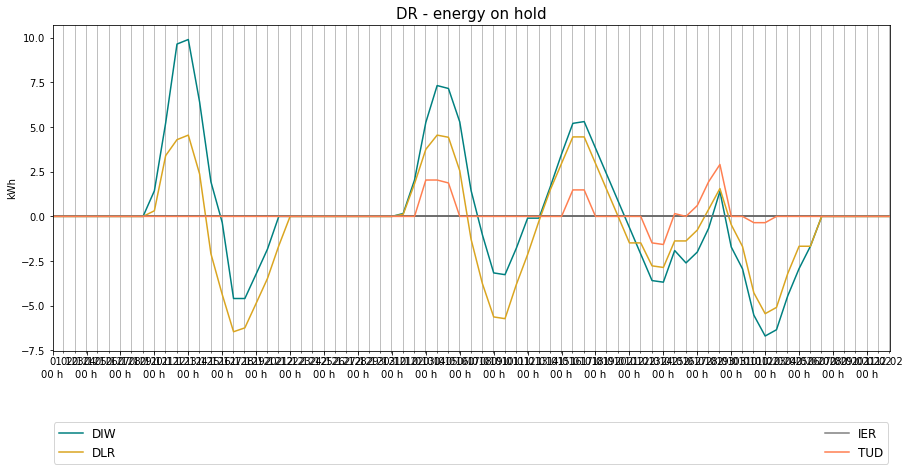

Plot_demand_shift_realistic_dsm_acum_.png saved.


In [36]:
draw_results_plot(dict_df_model, start, timesteps, tz, 'dsm_acum', False,
                  figure_size, 'DR - energy on hold', 'kWh', ds['drawstyle'], color, save=save_figs)

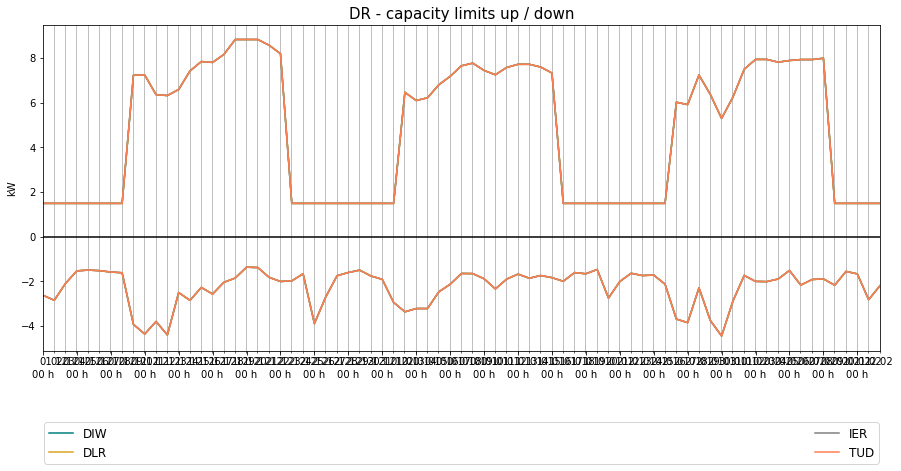

Plot_demand_shift_realistic_cap_up_cap_do_.png saved.


In [37]:
draw_results_plot(dict_df_model, start, timesteps, tz, ['cap_up', 'cap_do'], {'cap_up':False, 'cap_do': True},
                  figure_size, 'DR - capacity limits up / down', 'kW', ds['drawstyle'], color, save=save_figs)

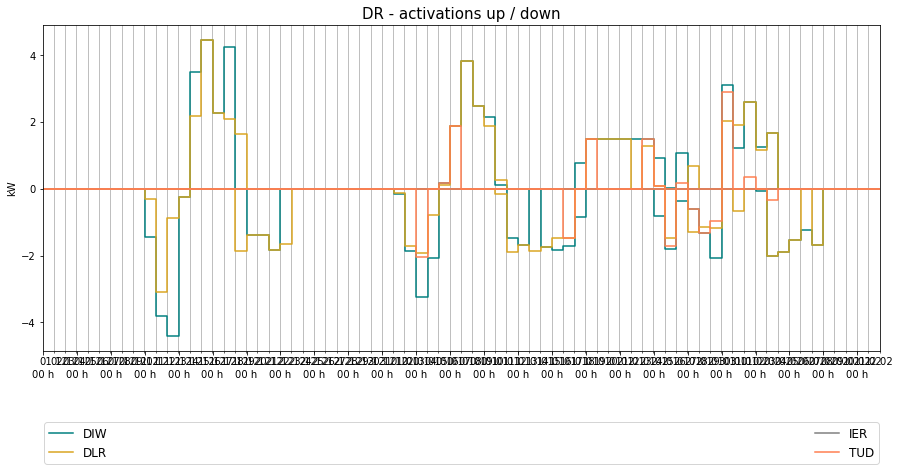

Plot_demand_shift_realistic_dsm_up_dsm_do_shift_.png saved.


In [38]:
draw_results_plot(dict_df_model, start, timesteps, tz, ['dsm_up', 'dsm_do_shift'], {'dsm_up':False, 'dsm_do_shift': True},
                  figure_size, 'DR - activations up / down', 'kW', 'steps-post', color, save=save_figs)